# 0.0 Tabel of Contents

[Fillout NA](#1.5-Fillout-NA) <br>
[Numerical Attibutes](#1.7.1-Numerical-Attributes)

# 0. IMPORTS

In [187]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import inflection
import math
import random
import pickle
import json
import datetime as datetime

from scipy import stats
from IPython.display import Image
from IPython.display import HTML
from boruta import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Lasso

import xgboost as xgb

## 0.1. Helper Functions

In [2]:
def time_series_cross_validation(kfold, training_set, model_name, model, verbose=False):
    '''
    kfold: quantity of folds
    training_set: traning set
    model_name: label, name of the model
    model: the model with its parameters
    verbose: print a message for every new kfold iteration
    '''
    
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in range(kfold,0,-1):
        if verbose:
            print(f'Kfold: {k}...')
        
        # data inicial e final para validação
        validation_start_date = training_set['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = training_set['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtro de datas
        training = training_set[(training_set['date'] < validation_start_date)]
        validation = training_set[(training_set['date'] >= validation_start_date) & (training_set['date'] <= validation_end_date)]

        # construção do dataset para o cross validation
        # para o treino
        x_training = training.drop(['date','sales'], axis=1)
        y_training = training['sales']
        # para a validação
        x_validation = validation.drop(['date','sales'], axis=1)
        y_validation = validation['sales']

        # model
        m = model.fit(x_training,y_training)

        # prediction
        yhat = m.predict(x_validation)

        # performance
        m_result = ml_error('Regressão linear',np.expm1(y_validation),np.expm1(yhat))

        # armazenar o resultado para iteração de k
        mae_list.append(m_result['MAE'].values)
        mape_list.append(m_result['MAPE_manual'].values)
        rmse_list.append(m_result['RMSE'].values)
        
    return pd.DataFrame(index=[model_name], 
                        data={'MAE': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                              'MAPE_manual': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                              'RMSE': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)})

def mean_percentage_error(y,yhat):
    return np.mean((y-yhat)/y)

def mean_absolute_percentage_error_manual(y,yhat):
    return np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape_manual = mean_absolute_percentage_error_manual(y, yhat)
    mape_sklearn = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame(index=[model_name], data= {'MAE':mae,
                                                 'MAPE_manual':mape_manual,
                                                 'MAPE_sklearn':mape_sklearn,
                                                 'RMSE':rmse})

def cramer_v(x,y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    # é necessário os valores da cm como uma matriz
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 =stats.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2/n - ((k-1)*(r-1)/(n-1)))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr) / (min(kcorr-1, rcorr-1)))


def jupyter_settings():
    # o comando mágico abaixo é para o kernel XPython mostrar os gráficos na célula
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    # para o pandas mostrar o dataframe completo, sem restrição no número de colunas a ser exibido, posso alterar a seguitne opção:
    pd.set_option('max_columns', None, "max_rows", 50)
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


c:\users\rnfavar.embad.000\miniconda3\envs\dev_ds_producao\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.2. Loading data

In [4]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory = False)
df_store_raw = pd.read_csv( 'data/store.csv', low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw,df_store_raw, how='left', on = 'Store' )

In [5]:
df_raw.sample(20).T

,710040,317110,158221,25704,968477,981803,785696,11581,91244,652093,24070,881532,307237,661393,736128,613927,966479,289655,917073,251991
Store,571,382,1007,60,328,274,407,432,930,604,656,353,876,984,1014,348,560,1090,214,784
DayOfWeek,4,1,4,3,3,5,6,2,1,7,5,4,5,6,2,6,5,3,7,1
Date,2013-10-03,2014-10-06,2015-03-12,2015-07-08,2013-02-13,2013-02-01,2013-07-27,2015-07-21,2015-05-11,2013-11-24,2015-07-10,2013-05-02,2014-10-17,2013-11-16,2013-09-10,2013-12-28,2013-02-15,2014-11-05,2013-03-31,2014-12-15
Sales,0,11833,4842,9718,4122,2946,3747,10861,6125,0,2725,4537,7378,6034,15376,8067,30143,8855,0,13982
Customers,0,887,627,816,540,860,298,1693,1041,0,359,1275,914,850,1706,673,2651,1011,0,1126
Open,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1
Promo,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1
StateHoliday,a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SchoolHoliday,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
StoreType,d,c,c,d,a,b,a,a,a,d,d,b,a,c,a,a,c,a,d,a


# 1.0. DESCRICAO DOS DADOS

In [6]:
# é interessante copiar o df no início de cada seção para evitar que, caso seja alterado o conteúdo do df, não seja necessário rodar todo o código novamente
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))
df1.columns = cols_new

## 1.2 Data Dimensions

In [8]:
# imprimir o número de linhas e colunas usando 2 maneiras de interpolar strings
print(f'Number of Rows: {df1.shape[0]}')
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [9]:
# inicialmente, o date é object
# deve-se alterar o tipo do date
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

Existem 3 métodos principais: <br>
    - Removo todas as linhas com NA: método possui a imensa desvantagem de perder muita informação <br>
    - Uso algum algoritmo para preencher os dados NA, como média, mediana ou algum ML para estimar os valores <br>
    - Entender a razão pela qual é NA; sempre devo começar por este método, pois eventualmente o NA era esperado
    

In [11]:
#competition_distance: distance in meters to the nearest competitor store

# o código abaixo revela que existem 3 lojas (622, 291 e 879) que possuem esta coluna em branco
stores = df1[df1["competition_distance"].isna()]["store"].value_counts()
display(stores)
print("\n")

# o código abaixo revela que existem as mesmas quantidades de linhas que trazem os dados destas stores em relação
# à quantidade de linhas com o valor da distância do competidor mais próximo igual a NA
# com isso conclui-se que todas as linhas dessas 3 stores estão, de fato, com o valor NA para competition_distance
for store in stores.index:
    print(df1[df1["store"] == store].shape[0])
print("\n")  
    
# portanto, é razoável assumir que este valor NA para a competition distance significa que não há loja competidora próxima
# será então substituída por um vlaor muito maior que a distância máxima
# antes, precisamos saber o a distância máxima presente no dataset
print((df1["competition_distance"].max()))
print("\n") 

# sabendo que a distância máximo é 75860, podemos substituir por 200.000, por exemplo
df1["competition_distance"] = df1["competition_distance"].fillna(200000)

# finalmente, checando se atribuiu corretamente
print("Após a modificação, agora há " + str(df1["competition_distance"].isna().sum()) + " valor faltante")

622    942
291    942
879    758
Name: store, dtype: int64



942
942
758


75860.0


Após a modificação, agora há 0 valor faltante


In [12]:
#competition_open_since_month:  gives the approximate year and month of the time the nearest competitor was opened

# para a primeira interação do CRISP, para aquelas lojas que eu não tenho a informação sobre quando a loja competidora abriu,
# vou simplesmente alocar o mesmo mês da linha de venda. Mesmo não sendo lógico, se for preciso na segunda interação do método CRISP
# poderei alterar esta atribuição.
# um motivo para essa suposição é que o mês e ano que uma loja competidora abriu pode significar um evento no comportamento de vendas
# tal evento pode ser detectado lá no feature selection
# logo, se o mês e ano da loja competidora "acompanham" o mês e ano da data da venda, não haverá nenhuma consequência nas vendas para as linhas que
# inicialmente estavam NA


x = lambda x: x["date"].month if math.isnan(x["competition_open_since_month"]) else x["competition_open_since_month"]
df1["competition_open_since_month"] = df1.apply(x, axis=1)

# o mesmo raciocínio para o "competition_open_since_month" vale para o "competition_open_since_year", promo2_since_week e promo2_since_year
#competition_open_since_year
x = lambda x: x["date"].year if math.isnan(x["competition_open_since_year"]) else x["competition_open_since_year"]
df1["competition_open_since_year"] = df1.apply(x, axis=1)

#promo2_since_week
x = lambda x: x["date"].week if math.isnan(x["promo2_since_week"]) else x["promo2_since_week"]
df1["promo2_since_week"] = df1.apply(x, axis=1)

#promo2_since_year
x = lambda x: x["date"].year if math.isnan(x["promo2_since_year"]) else x["promo2_since_year"]
df1["promo2_since_year"] = df1.apply(x, axis=1)


In [13]:
#promo_interval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. 
#E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# para a primeira rodada do CRISP, será atribuído o valor 0 (zero) para os dados faltantes da coluna "promo_interval"
df1["promo_interval"].fillna(0, inplace = True)

# a seguir, será verificado se o mês da data da linha é mês de início de rodada da promo2 e atribuído à nova coluna "is_promo:
# 0 (quando não é mês de de início) ou 1 (quando é mês de início)
month_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug",9: "Sept", 10: "Oct", 11: "Nov",12: "Dec"}
df1["month_map"] = df1["date"].dt.month.map(month_map)

# escrevi 2 maneiras de executar a função que popula a nova coluna "is_promo"
# a primeira demora +10 min e por isso foi inteiramente comentada:

#def isPromo(df):
#    if df["promo_interval"] == 0:
#        df["is_promo"] = 0
#    else:
#        if df["month_map"] in df["promo_interval"].split(','):
#            df["is_promo"] = 1
#        else:
#            df["is_promo"] = 0
#    return df
            
# df1["is_promo"] = df1[["promo_interval","month_map"]].apply(isPromo, axis = 1)["is_promo"]
# Last executed at 2021-04-08 09:14:02 in 13m 57.15s


# a segunda demora menos de 15 segundos:
df1["is_promo"] = df1[["promo_interval","month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(',') else 0, axis = 1)
# Last executed at 2021-04-08 08:53:43 in 11.97s

In [14]:
# confirma que todos os dados faltantes foram tratados
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types


In [15]:
# as operações realizadas em 1.5 podem ter mudado os tipos das colunas.
# por isso é importante checar novamente
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
# mudar o tipo das colunas que tem semana, mês e ano
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)
df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

# a princípio não há nenhum problema em deixar algumas colunas como int32 e outras como int64
# caso seja necessária a conversão: valor_64 = np.int64(valor32_a_ser_convertido)

## 1.7 Descriptive Statistical

A partir deste momento, passamos para a exploração dos dados da metodologia CRISP

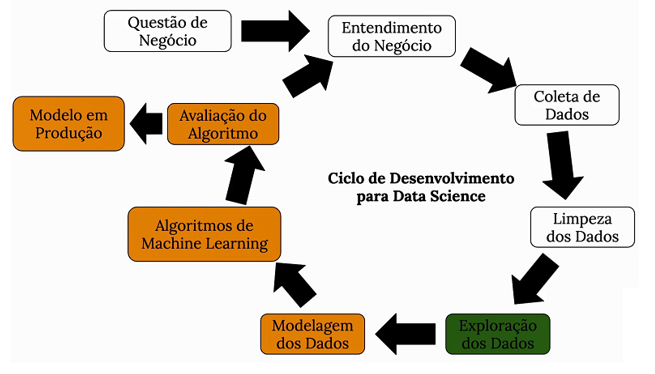

In [17]:
Image("img/crisp.png")

Métricas: <br>
* Tendência central: média, mediana
* Dispersão: variância, desvio padrão, amplitude

Embora a estatística descritiva seja compatível com dados numéricos e categóricos, a forma de construção é diferente. Portanto, preciso separar em dados numéricos e dados categóricos.

In [18]:
num_attributes = df1.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'int64', 'float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [19]:
# mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.skew()).T
d6 = pd.DataFrame(num_attributes.kurtosis()).T

# concat
metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


A seguir, alguns exemplos de distribuição das variáveis para começarmos a entender a distribuição da quantidade de registros de cada uma delas:

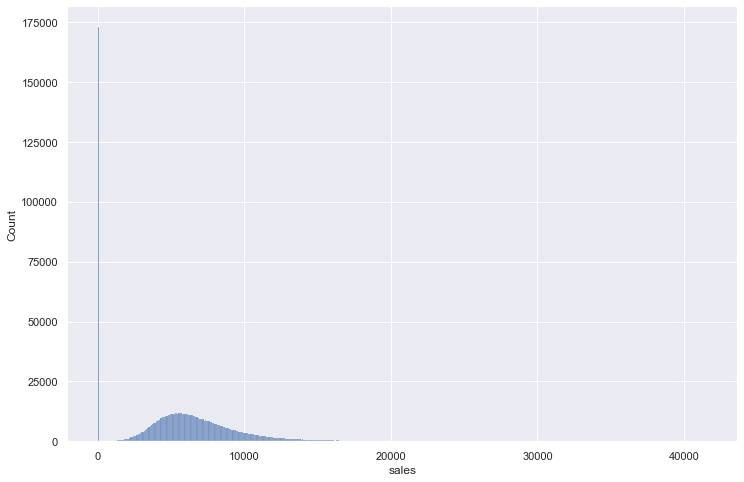

In [20]:
plt.figure(figsize=(12,8))
sns.histplot(df1["sales"]);

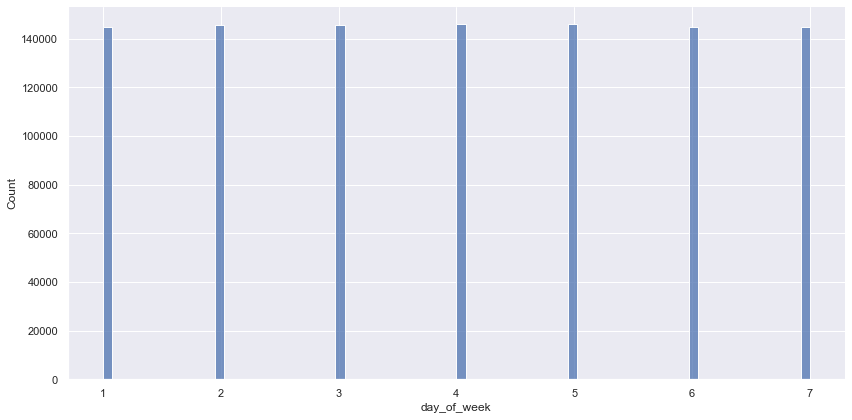

In [21]:
sns.displot(df1["day_of_week"], height=6, aspect=2);

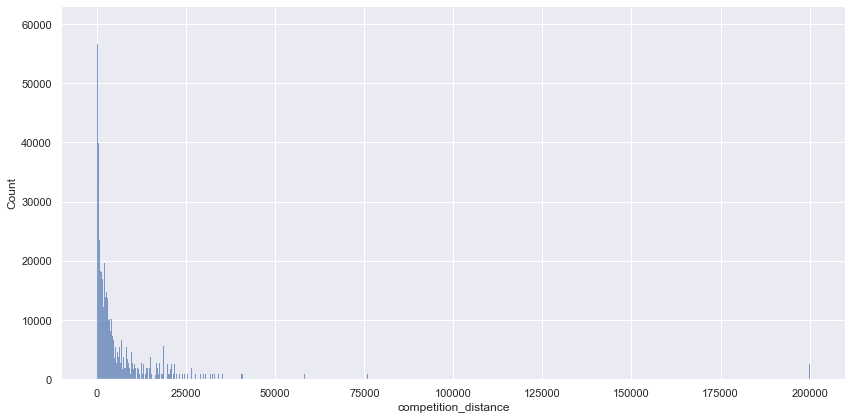

In [22]:
sns.displot(df1["competition_distance"], height=6, aspect=2);

### 1.7.2 Categorical Attributes

In [23]:
cat_attributes.apply(lambda x: x.unique().shape[0])

# outra maneira de obter o mesmo resultado
#cat_attributes.nunique()

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

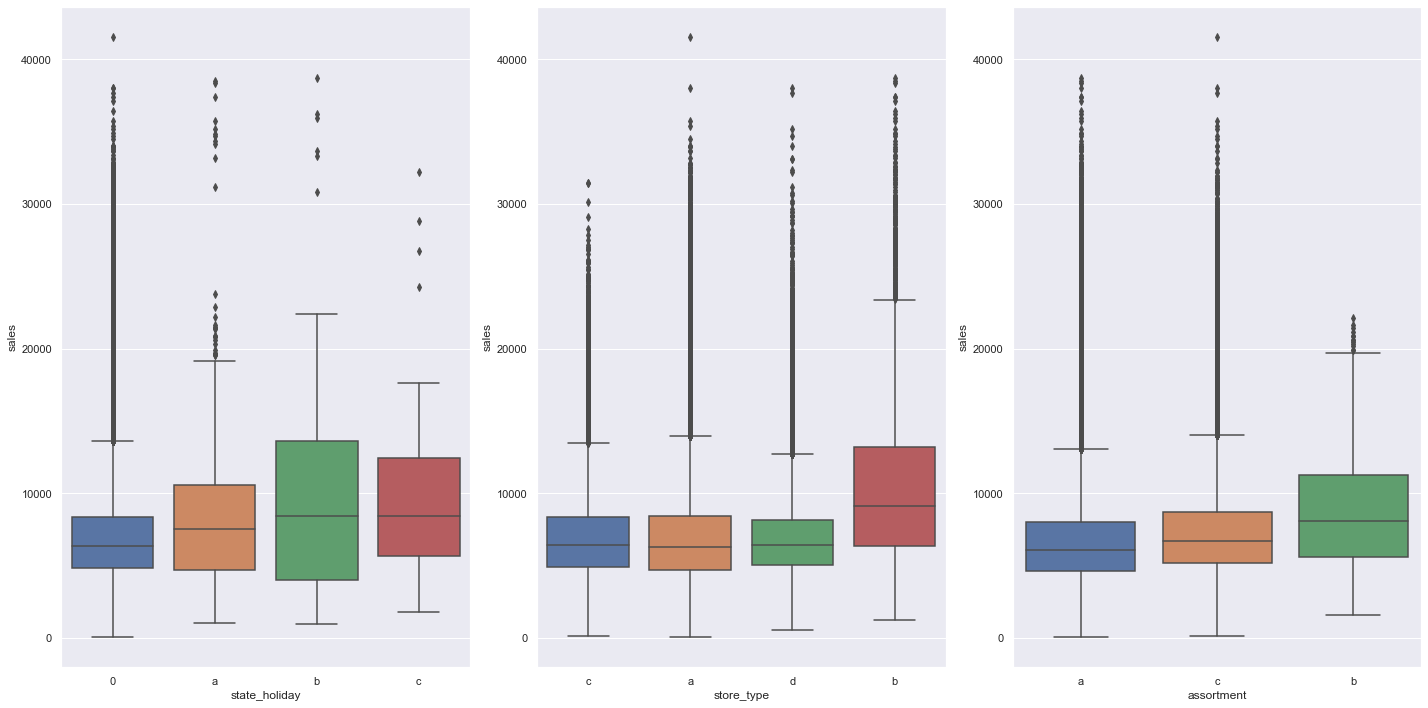

In [24]:
# desconsiderar quando as lojas estavam fechadas ou quando a venda foi nula
aux1 = df1[(df1["open"] == 1) & (df1["sales"] > 0)]
sns.set_style("darkgrid")
plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.boxplot(x="state_holiday", y="sales", data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x="store_type", y="sales", data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x="assortment", y="sales", data=aux1)

plt.tight_layout()

Nos gráficos de boxplot acima, os outliers são aqueles considerados acima de 1.5  do intervalor interquartil (IQR, em inglês)
A imagem abaixo ilustra isso

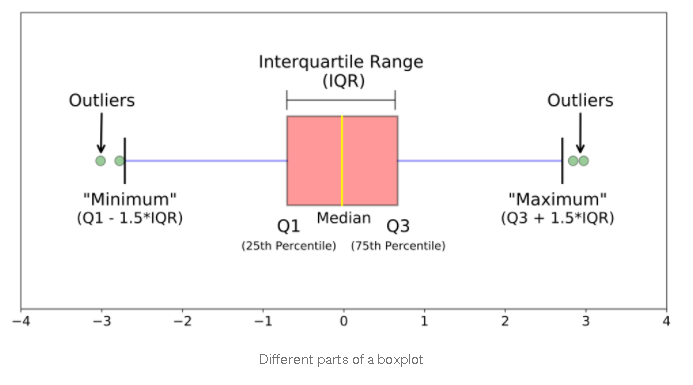

In [25]:
# fonte: https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51
Image("img/box_plot.png")

# 2.0 FEATURE ENGINEERING

In [26]:
df2 = df1.copy()

## 2.1 Mapa mental de hipóteses

Mapa mental de hipóteses:
* Fenômeno: O que estou modelando (Daily Store Sales)
* Agentes: Quais são os agentes que atuam sobre o fenômeno (cinco galhos principais)
* Atributos dos Agentes: Qual a descrição dos agentes (galhos em cada um dos agentes) <br>

O objetivo é derivar uma lista de hipóteses para podermos validá-las ou não com os dados.
Cada hipótese validada ou descartada é o insight.

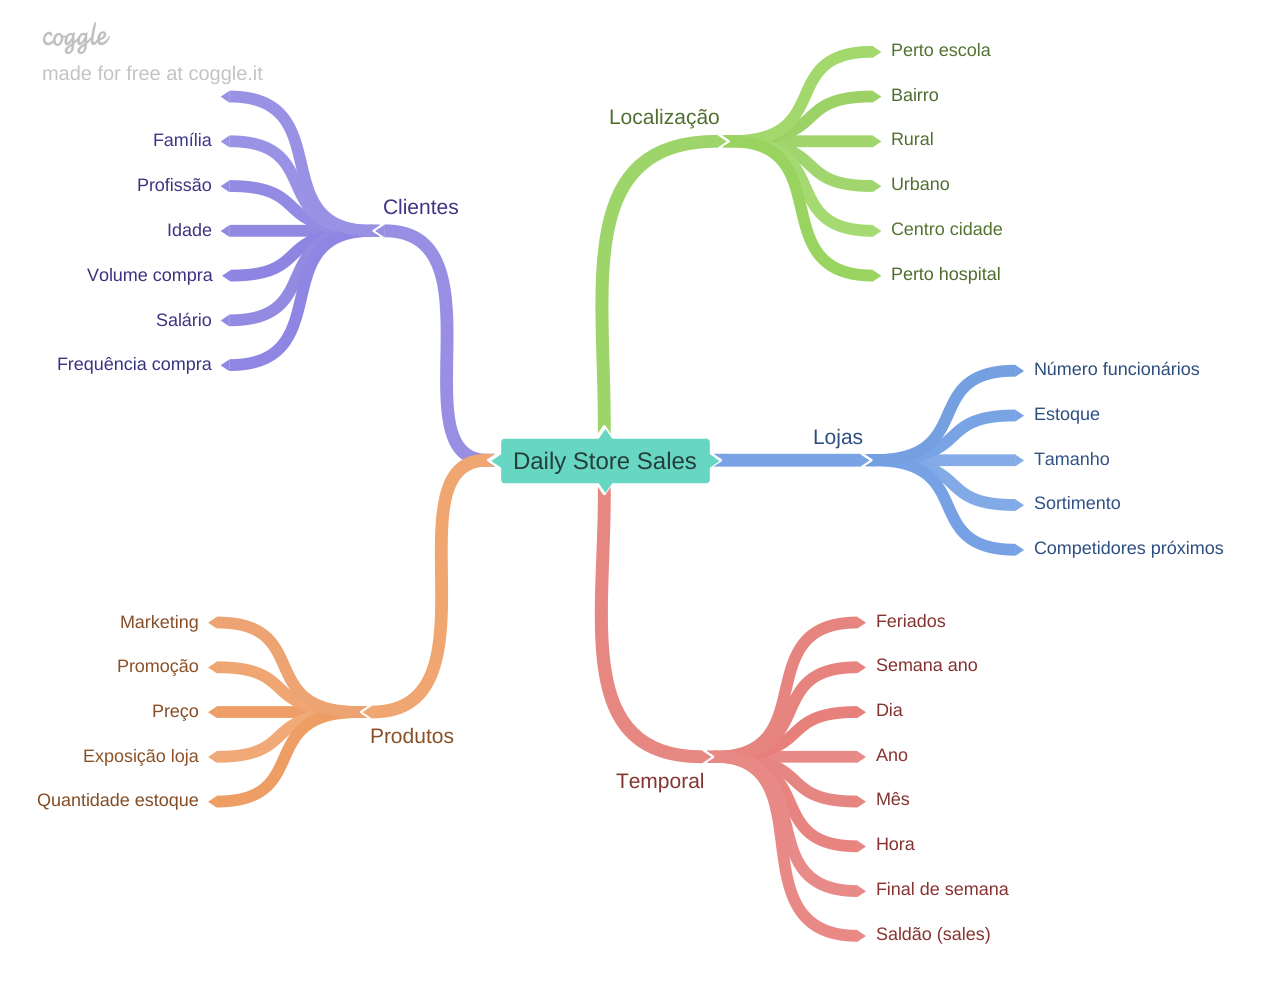

In [27]:
# gerado com ajuda de https://coggle.it/
Image("img/MindMapHypothesis.png")

O mapa mental de hipóteses acima será utilizado para extrair hipóteses para validá-las, mais a frente, durante a análise exploratória de dados.
Para escrever hipóteses, considerá-las como uma aposta, conforme os exemplos abaixo: <br>
"Lojas de MAIOR porte deveriam vender MAIS." (Repare que estou citando um atributo de um agente (Tamanho da loja) e apostando na correlação sobre a variável resposta (vendas). <br>
"Lojas de MAIOR sortimento deveriam vender MAIS." <br>
"Lojas com MAIS competidores por perto deveriam vender MENOS."


## 2.1 Criação das hipóteses

### 2.1.1. Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais <br>
**2.** Lojas com maior estoque deveriam vender mais <br>
**3.** Lojas com maior porte deveriam vender mais (ou Lojas com menor porte deveriam vender menos) <br>
**4.** Lojas com maior sortimento deveriam vender mais <br>
**5.** Lojas com competidores mais próximos deveriam vender menos <br>
**6.** Lojas com competidores à mais tempo deveriam vender mais

### 2.1.2. Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais <br>
**2.** Lojas que expõem mais nas vitrines da loja deveriam vender mais <br>
**3.** Lojas onde os produtos custam menos deveriam vender mais <br>
**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais <br>
**5.** Lojas onde os produtos custam menos por mais tempo (promoções ativas) deveriam vender mais <br>
**6.** Lojas com mais dias de promoção deveriam vender mais <br>
**7.** Lojas com mais promoções estendidas deveriam vender mais <br> 

### 2.1.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais <br>
**2.** Lojas deveriam vender mais ao longo dos anos <br>
**3.** Lojas deveriam vender mais no segundo semestre do ano <br>
**4.** Lojas deveriam vender mais depois do dia 10 de cada mês <br>
**5.** Lojas deveriam vender menos aos finais de semana <br>
**6.** Lojas deveriam vender menos durante os feriados escolares <br>
**7. (extra)** Lojas que abrem nos finais de semana deveriam vender mais <br>


## 2.2 Priorização de hipóteses

Como estamos trabalhando no método CRISP, vamos validar as hipoteses que já temos condições de verificá-las com o conjunto atual de dados obtidos. Se para a hipótese for necessário fazer mais um query no SQL, extrair, armazenar e tratar os dados, então é melhor fazer em um próximo ciclo do CRISP, caso necessário. <br>
As hipóteses abaixo foram extraídas das seções 2.1.1 a 2.1.3 pois, no dataset disponível, são as únicas que podem ser verificadas.

**1.** Lojas com maior sortimento deveriam vender mais <br>
**2.** Lojas com competidores mais próximos deveriam vender menos <br>
**3.** Lojas com competidores à mais tempo deveriam vender mais <br>

**4.** Lojas onde os produtos custam menos por mais tempo (promoções ativas) deveriam vender mais <br>
**5.** Lojas com mais dias de promoção deveriam vender mais <br>
**6.** Lojas com mais promoções estendidas deveriam vender mais <br> 

**7** Lojas abertas durante o feriado de Natal deveriam vender mais <br>
**8.** Lojas deveriam vender mais ao longo dos anos <br>
**9.** Lojas deveriam vender mais no segundo semestre do ano <br>
**10.** Lojas deveriam vender mais depois do dia 10 de cada mês <br>
**11.** Lojas deveriam vender menos aos finais de semana <br>
**12.** Lojas deveriam vender menos durante os feriados escolares <br>
**13. (extra)** Lojas que abrem nos finais de semana deveriam vender mais <br>

## 2.3 Feature Engineering

In [28]:
# criação de novas colunas para utilizá-las na AED e validação/refutação das hipóteses selecionadas

# year
df2["year"] = df2["date"].dt.year

# month
df2["month"] = df2["date"].dt.month

# day
df2["day"] = df2["date"].dt.day

# week of year
df2["week_of_year"] = df2["date"].dt.isocalendar().week #capturar a semana do ano

# year week
df2["year_week"] = df2["date"].dt.strftime('%Y-%W')

# competition_time_month (precisa juntar o ano e mês primeiro)
df2["competition_since"] = df2.apply(lambda x: datetime.datetime(year = x["competition_open_since_year"], month = x["competition_open_since_month"], day = 1), axis = 1)
df2["competition_time_month"] = ((df2["date"] - df2["competition_since"]) / 30).apply(lambda x: x.days).astype(int)

# promo since (queremos saber o tempo que a loja aderiu a promo2 )
# como a semana %W começa com 0, subtrai-se 7 dias
df2["promo_since"] = df2["promo2_since_year"].astype(str) +  '-' + df2["promo2_since_week"].astype(str)
df2["promo_since"] = df2["promo_since"].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))

# promo_time_week
df2["promo_time_week"] = ((df2["date"] - df2["promo_since"])/7).apply(lambda x: x.days).astype(int)

# assortment
df2["assortment"] = df2["assortment"].map({'a': 'basic', 'b': 'extra', 'c': 'extended'})

# state holiday
df2["state_holiday"] = df2["state_holiday"].map({'a':'public_holiday', 'b':'easter_holiday', 'c':'christmas', '0': 'regular_day'})


In [29]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [30]:
df2.state_holiday.value_counts()

regular_day       986159
public_holiday     20260
easter_holiday      6690
christmas           4100
Name: state_holiday, dtype: int64

# 3.0 FILTRAGEM DE VARIÁVEIS

A motivação para a filtragem de negócios são as restrições de negócio. É possível que, lá na frente, o CD se depara com a impossibilidade de colocar o modelo em produção. Isso ocorre, principalmente, devido à falta de consideração das restrições de negócio. Por isso ela é importante estar dentro do início do ciclo do CRISP. <br>
Um exemplo de restrição de negócios que foi mencionado na aula: no desenvolvimento de um projeto para previsão de vendas de um produto, verificou-se que a variável "desconto aplicado" tinha forte correlação com o volume de vendas. O modelo então foi treinado usando-se essa variável. Mas o time de negócios falou que era impossível saber o desconto antes do produto ser lançado. Logo, no momento da predição, na produção, não é possível usá-la. Por isso é importante filtrar as variáveis antes de começar o projeto em si.

In [31]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [32]:
# a coluna "open" indica se a loja está aberta (1) ou fechada (0); porém quando ela está fechada, as vendas são 0; logo não tenho nenhum aprendizado extraído das linhas onde "open" é igual a 0
# a coluna "sales" quando indica o valor 0, semelhantemente em relação à coluna "open", não há aprendizado a ser extraído, logo não usarei as linhas onde isso ocorre

df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [33]:
# a coluna "customers" não temos no momento da predição; não sabemos quantos customers terão daqui 6 semanas (para isso seria necessário um outro projeto)
# também serão excluídas as colunas 'open' (que após 3.1 só apresenta o valor '1') e as colunas 'promo_interval' e 'month_map' que foram utilizadas para derivar a coluna 'is_promo'
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis=1)

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

Como as variáveis impactam o fenômeno & qual é a força desse impacto?

Os 3 objetivos da EDA:
- Ganhar experiência de negócio
- Validar hipóteses de negócio (insights)
    - Gerar surpresa e contrapor crenças cristalizadas empiricamente pelo time de negócios
- Perceber variáveis que são importantes para o modelo

As seguintes análises serão efetuadas na EDA:
- Análise univariada
    - Como é essa variável (min, max, range, distribuição) ?
- Análise bivariada
    - Como a variável impacta no atributo alvo (carrelação, validação das hipóteses) ?
- Análise multivariada
    - Como as variáveis se relacionam (correlação entre elas) ?

In [34]:
df4 = df3.copy()

Antes de iniciar as próxima seções, vamos atualizar a análise descritiva dos dados:

In [35]:
num_attributes = df4.select_dtypes(include=['int32', 'int64', 'float64'])
# mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.skew()).T
d6 = pd.DataFrame(num_attributes.kurtosis()).T

# concat
metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.421374,558.0,321.730671,0.000426,-1.198836
1,day_of_week,1.0,7.0,6.0,3.520350,3.0,1.723711,0.019310,-1.259347
2,sales,46.0,41551.0,41505.0,6955.959134,6369.0,3103.813677,1.594929,4.854027
3,promo,0.0,1.0,1.0,0.446356,0.0,0.497114,0.215824,-1.953425
4,school_holiday,0.0,1.0,1.0,0.193578,0.0,0.395102,1.551109,0.405939
5,competition_distance,20.0,200000.0,199980.0,5961.827515,2330.0,12592.173650,10.134908,145.288658
6,competition_open_since_month,1.0,12.0,11.0,6.787355,7.0,3.309915,-0.048451,-1.231875
7,competition_open_since_year,1900.0,2015.0,115.0,2010.331102,2012.0,5.502625,-7.217323,123.903078
8,promo2,0.0,1.0,1.0,0.498670,0.0,0.499998,0.005320,-1.999976
9,promo2_since_week,1.0,52.0,51.0,23.629083,22.0,14.288306,0.170399,-1.194815


## 4.1 Análise univariada

### 4.1.1 Target variable

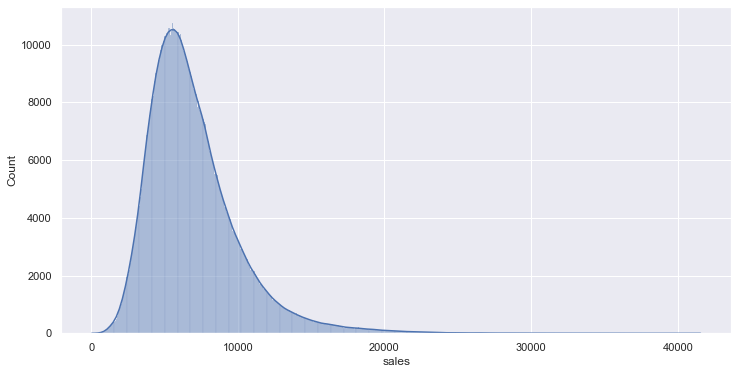

In [36]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(df4['sales'], kde = True, ax = ax)
plt.show()

Uma curiosidade: foi mencionado que ao aplicar o log1p na distribuição (que não é normal) deixaria a distribuição "mais normal"; entretanto, usando o normal test do scipy não notamos diferença. Este tópico certamente será muito discutido ao longo dos meus estudos e deixo registrado aqui esta observação.
Outro método que foi mencionada para transformar a distribuição em normal é a boxcox, que também não alterou o valor do p no normaltest. 
No início do módulo 5, um aluno falou do teste Shapiro. O p-valor não mudou, mas nota-se a mudança no "statistic"; um dia retorno a esse ponto para escrever mais sobre essas transformações e seus testes.

In [37]:
a = (df4['sales']) 
b = np.log1p(df4['sales'])  #transf. log1p
c, _ = stats.boxcox(df4['sales']) #trans. boxcox
testes = ['a', 'b', 'c']

for teste in testes:
    k2, p = stats.normaltest(eval(teste))
    #shapiro_test = stats.shapiro(eval(teste))
    print(f'O p valor de {teste} é {p}')
    #print(f"O teste shapiro é {shapiro_test} \n")

O p valor de a é 0.0
O p valor de b é 0.0
O p valor de c é 0.0


Um ponto interessante é que se a amostra for menor, há sim um evidente aumento do p_valor, conforme esperado, após a transformação. Essa depência do tamanho da amostra com o p_valor também será alvo de futuras investigações.

In [38]:
sample = df4['sales'].sample(1000, random_state=41896)
a = sample
b = np.log1p(sample)  #transf. log1p
c, _ = stats.boxcox(sample) #trans. boxcox
testes = ['a', 'b', 'c']

for teste in testes:
    k2, p = stats.normaltest(eval(teste))
    #shapiro_test = stats.shapiro(eval(teste))
    print(f'O p valor de {teste} é {p}')
    #print(f"O teste shapiro é {shapiro_test} \n")

O p valor de a é 8.327224614050526e-64
O p valor de b é 0.003646314058067798
O p valor de c é 0.11362310846342781


### 4.1.2 Numerical variable

c:\users\rnfavar.embad.000\miniconda3\envs\dev_ds_producao\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


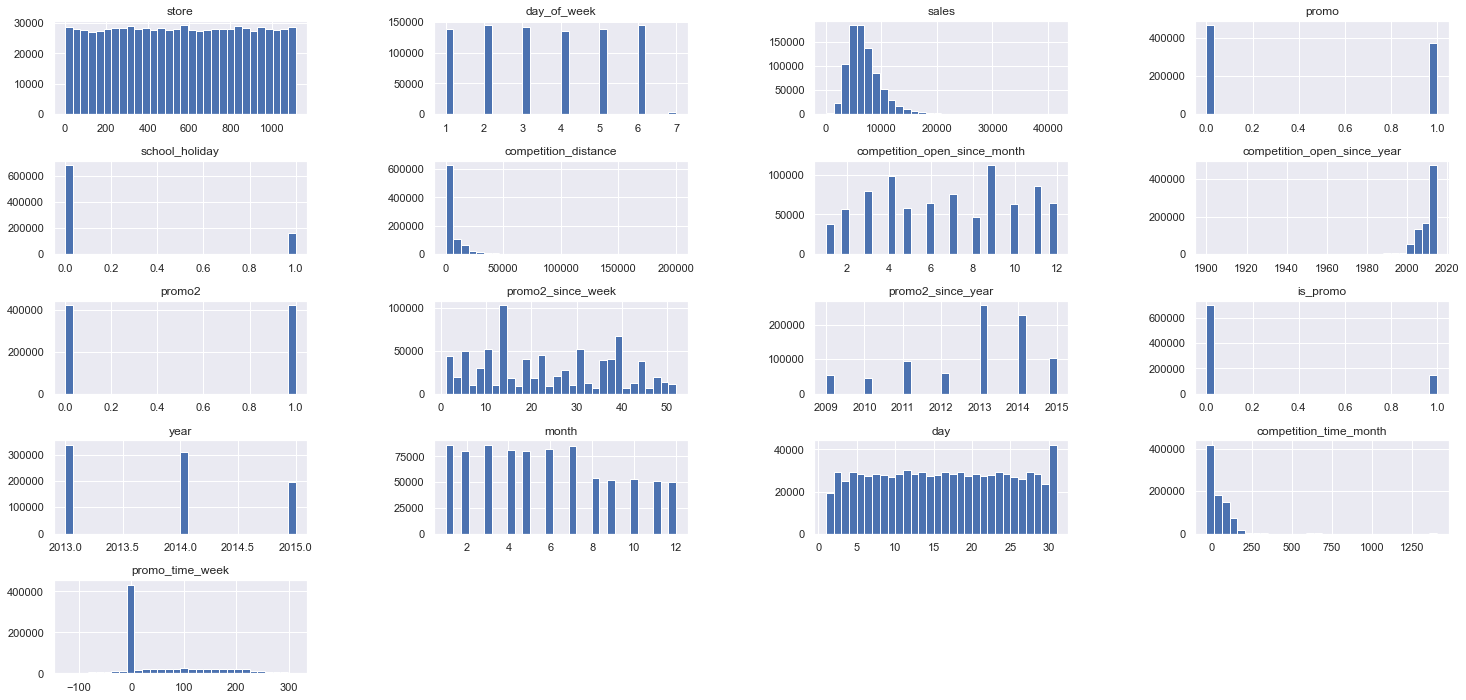

In [39]:
ax = num_attributes.hist(bins=30, figsize = (25,12), layout=(5,4));
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

Algumas análises preliminares:
- o número de dados de cada loja é aproximadamente igual
- a disponibilização de dadoos de venda em cada um dos 7 dias da semana também é uniforme
- a distribuição do valor das vendas obtidos pelas diferentes lojas não segue uma distribuição normal
- a mesma distribuição das vendas parece ocorrer para o número de clientes
- a maior parte dos competidores parece que abriram em setembro, seguido por abril
- a promo2 está presente em metade dos dados disponíveis
- o ano onde mais ocorreu início da promo2 foi 2013
- a promo2 parece que tende a iniciar mais no primeiro semestre do ano (26 primeiras semanas)
- não há nenhuma distribuição normal

### 4.1.3 Categorical variable

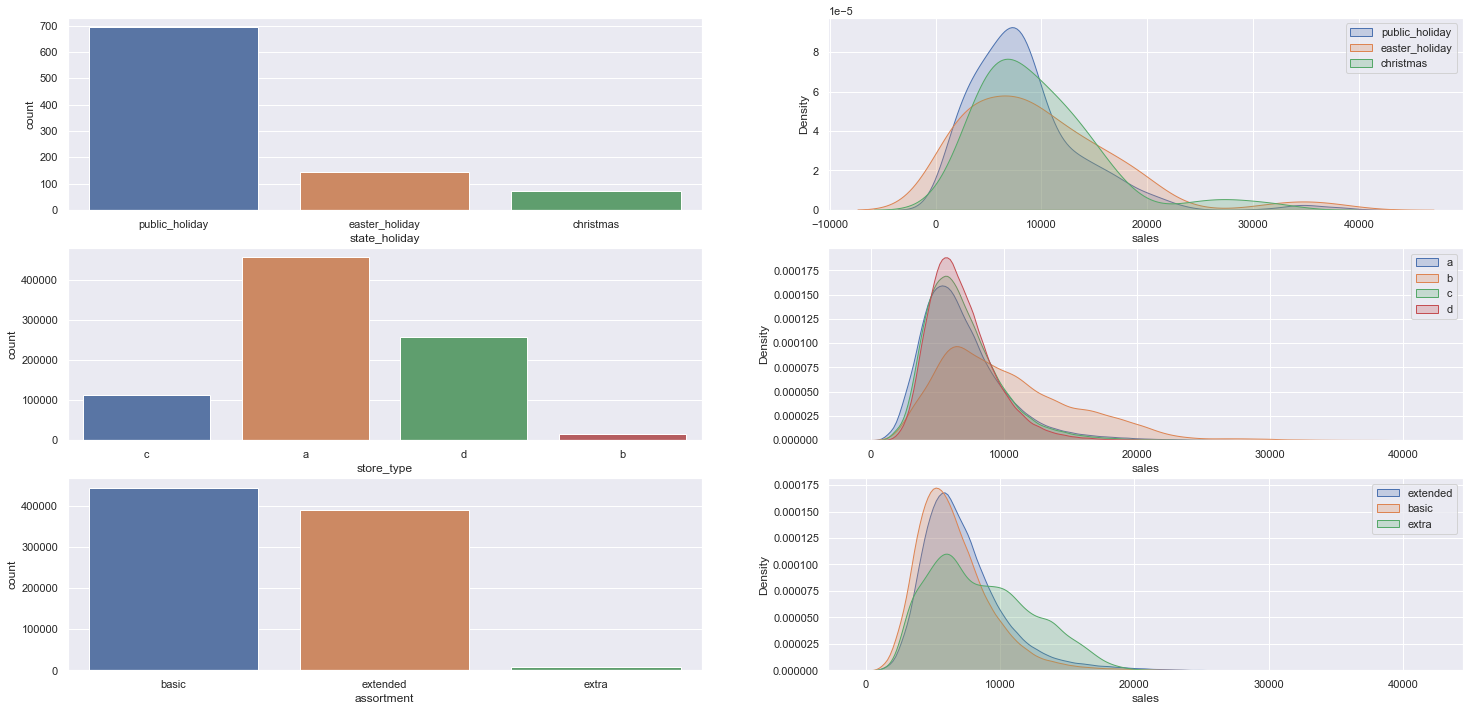

In [40]:
plt.figure(figsize=(25,12))

# state_holiday
plt.subplot(3,2,1)
sns.countplot(data = df4[df4['state_holiday'] != 'regular_day'],x = 'state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)
plt.legend()

# store_type
plt.subplot(3,2,3)
sns.countplot(data = df4, x = 'store_type')

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(data = df4, x = 'assortment')

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade=True)

plt.legend()

plt.show()

Na figura acima, à esquerda, tem-se a quantidade de dados presentes para as variáveis categóricas: 'state_holiday' (excluindo-se o 'regular_day' que é a maior parte dos dados), 'store_type' e 'assortment'. Na direita, tem-se a distribuição do valor de vendas dessas mesmas variáveis categóricas em relação ao valor das vendas, já iniciando, portanto, a análise bivariada que será muito mais trabalhada na seção seguinte, com a validação ou refutação das diferentes hipóteses levantadas.

## 4.2 Análise bivariada

Todas as hipóteses priorizadas na seção 2.2 serão validadas ou refutadas nesta seção.

### H1. Lojas com maior sortimento deveriam vender mais

**verdadeira:** lojas com maior sortimento tendem a vender mais

Primeiramente, observa-se a quantidade de cada loja representante de cada sortimento.

In [41]:
df4[['store','assortment']].drop_duplicates().groupby('assortment').count()

,store
assortment,
basic,593
extended,513
extra,9


Como há considerável variação, principalmente em relação aos tipos "extra", vamos efetuar uma análise do desempenho médio por cada um desses tipos de sortimento presentes nas lojas.

In [42]:
df4[['assortment', 'sales']].groupby('assortment').describe()

sales                                                                    
               count         mean          std     min     25%     50%      75%      max
assortment                                                                              
basic       444875.0  6621.523057  2972.050174    46.0  4611.0  6082.0   8000.0  38722.0
extended    391254.0  7300.843547  3183.849717   133.0  5156.0  6675.0   8703.0  41551.0
extra         8209.0  8642.503594  3803.116031  1580.0  5606.0  8088.0  11271.0  22137.0

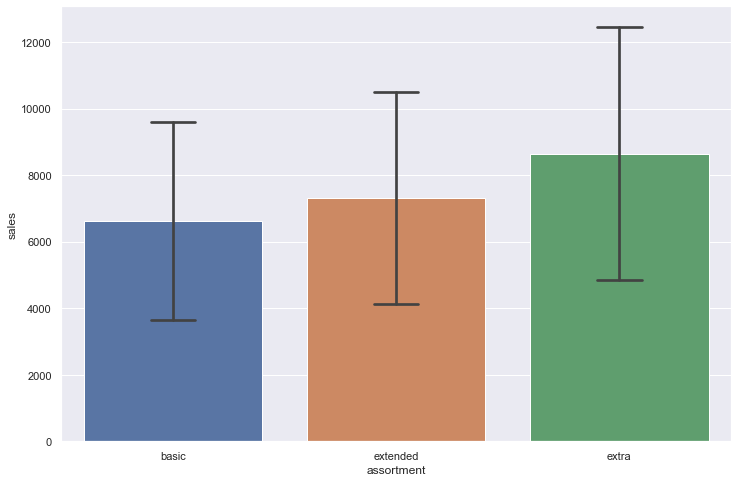

In [43]:
plt.figure(figsize=(12,8))
sns.barplot(x = 'assortment', y='sales', data = df4, estimator = np.mean, ci = 'sd',capsize=.2);

Para investigar o efeito sazonal de tais vendas em relação aos diferentes tipos de sortimento podemos criar uma série temporal

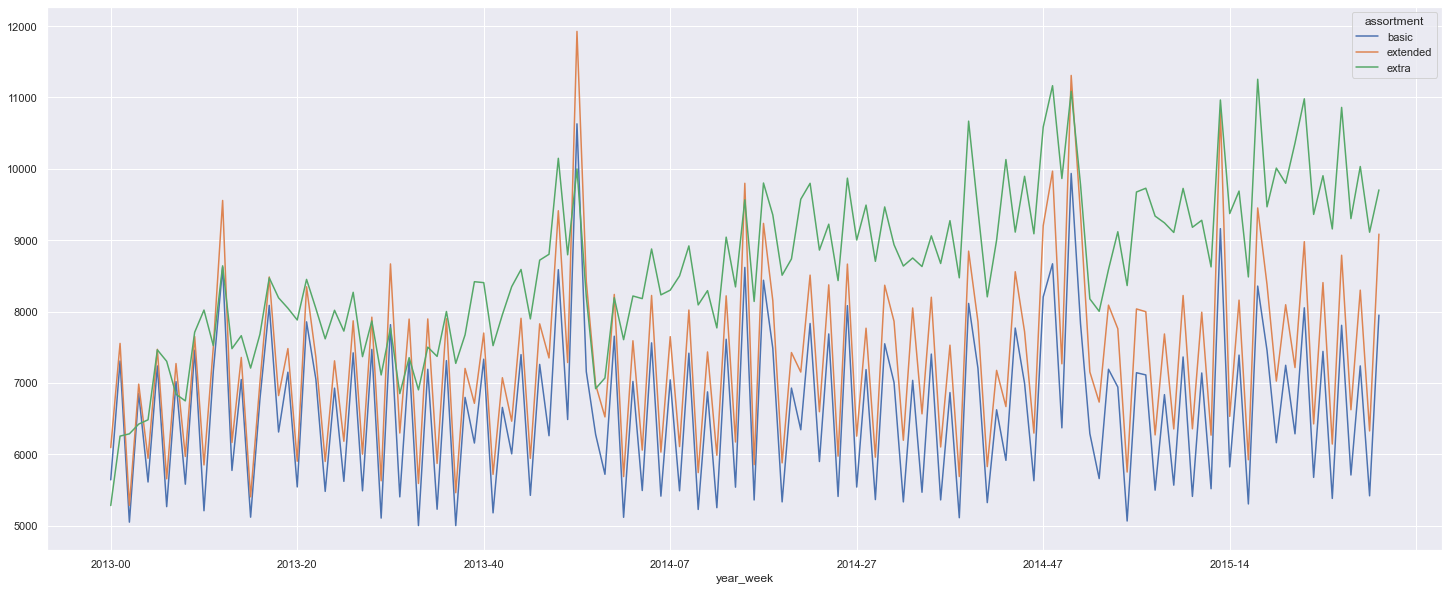

In [44]:
aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux1.pivot(index='year_week', columns = 'assortment', values='sales').plot(figsize=(25,10));

Aparentemente há um descolamento do resultado de vendas obtido conforme o tempo passa para as lojas com sortimento "extra", em relação àquelas com sortimento "basic" e "extended".
Ao observar a média móvel mensal (4 semanas) fica mais nítido tal efeito.

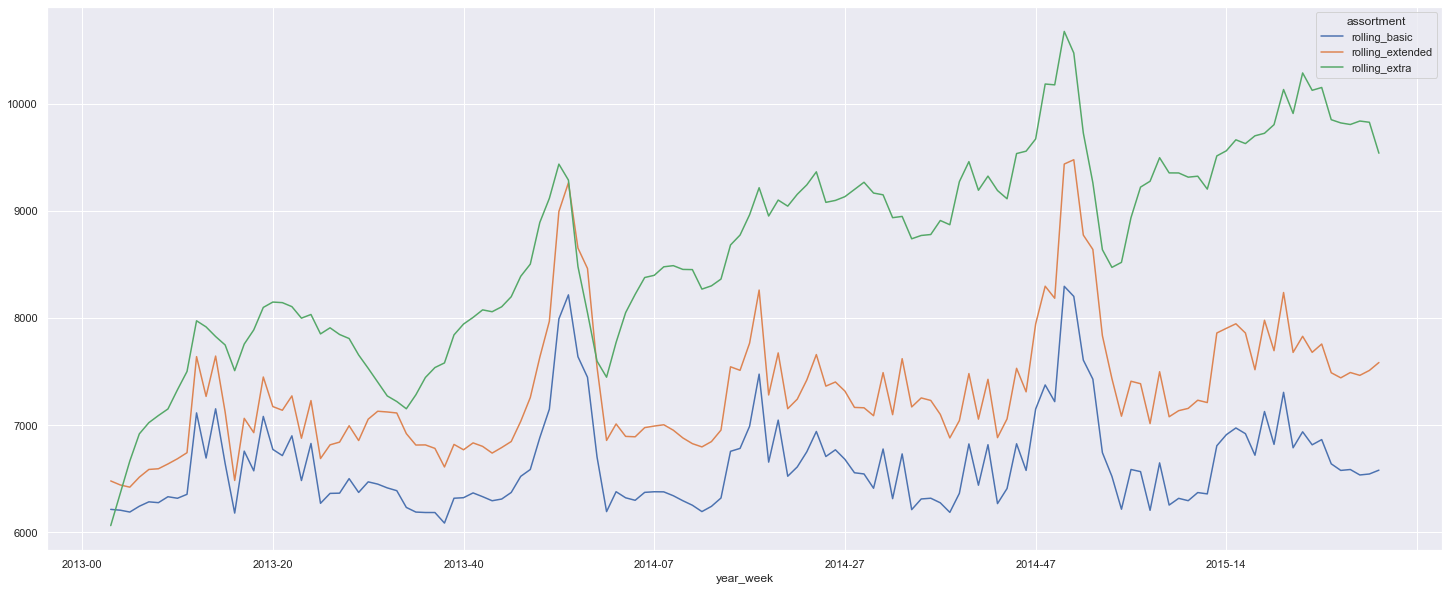

In [45]:
aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2 = aux1.pivot(index='year_week', columns = 'assortment', values='sales').reset_index()

aux2['rolling_basic'] = aux2['basic'].rolling(4).mean()
aux2['rolling_extended'] = aux2['extended'].rolling(4).mean()
aux2['rolling_extra'] = aux2['extra'].rolling(4).mean()
aux2 = aux2.set_index('year_week')[['rolling_basic','rolling_extended','rolling_extra' ]]
aux2.plot(figsize=(25,10));


O veredito da hipótese H1 é que **"sim, lojas com maior sortimento tendem a vender mais"**

Chamo a atenção para o cuidado ao escolher a função estatística por trás de cada um desses gráficos. Na aula foi invocada a função "sum" ao invés de "mean" o que inverteu completamenet as análises:
- as vendas de lojas com sortimento "basic" pareceram maiores em relação ao sortimento "extended";
- as vendas de lojas com sortimento "extra" apareceram como sendo ínfimas

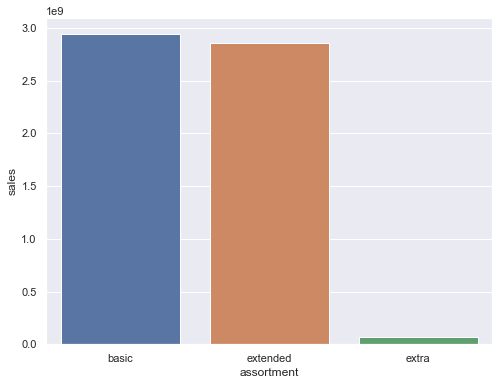

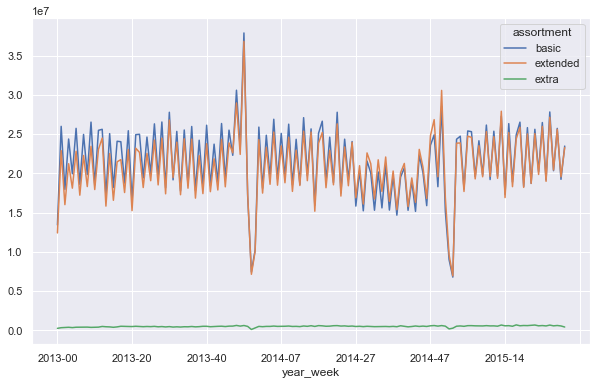

In [46]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'assortment', y='sales', data=df4[['assortment', 'sales']].groupby('assortment').sum().reset_index());

aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux1.pivot(index='year_week', columns = 'assortment', values='sales').plot(figsize=(10,6));

### H2. Lojas com competidores mais próximos deveriam vender menos
**falsa:** não, lojas com competidores mais próximos não vendem menos (ou mais) do que as lojas com competidores mais distantes


Ao plotar o valor médio de vendas em diferentes pequenos agrupamentos de intervalo de distância tem-se a distribuição a seguir:

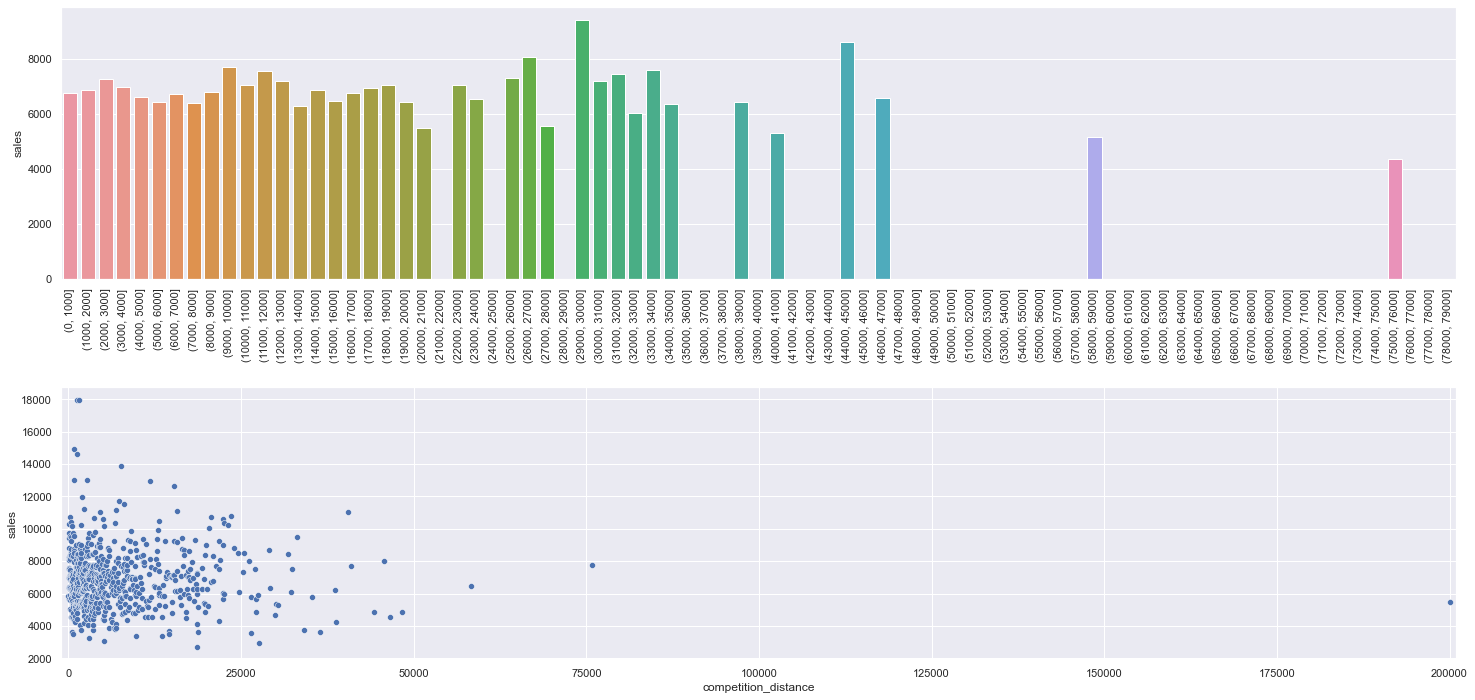

In [47]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
bins = list(np.arange(0,80000, 1000))
aux1['competition_distance_binned'] = pd.cut(df4['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').mean().reset_index()
plt.figure(figsize=(25,12))
plt.subplot(2,1,1)
plt.subplots_adjust(hspace=.4)
sns.barplot(data=aux2, x='competition_distance_binned', y='sales')
plt.xlabel("")
plt.xticks(rotation=90)

plt.subplot(2,1,2)
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1)
plt.xlim(-1000,201000);


Pelos gráficos acima, não há nenhuma correlação aparente entre o valor médio de vendas e a distância do competidor mais próximo. Tal observação é confirmada ao plotar o gráfico de correlação de Pearson a seguir:

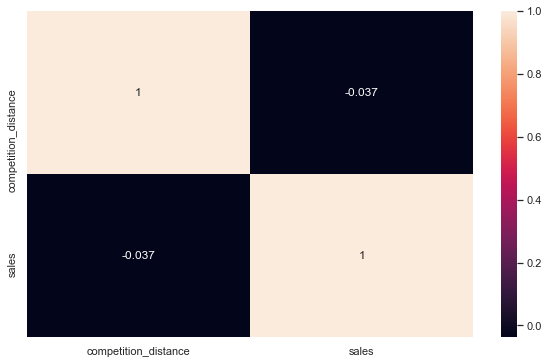

In [48]:
plt.figure(figsize=(10,6))
sns.heatmap(aux1.corr(method='pearson'),annot=True);

O veredito da hipótese H2 é que **"não, lojas com competidores mais próximos não vendem menos (ou mais) do que as lojas com competidores mais distantes "**

O mesmo comentário da H1 é feito aqui: se ao invés de considerar a média for considerada a soma das vendas, as análises serão completamente diferentes

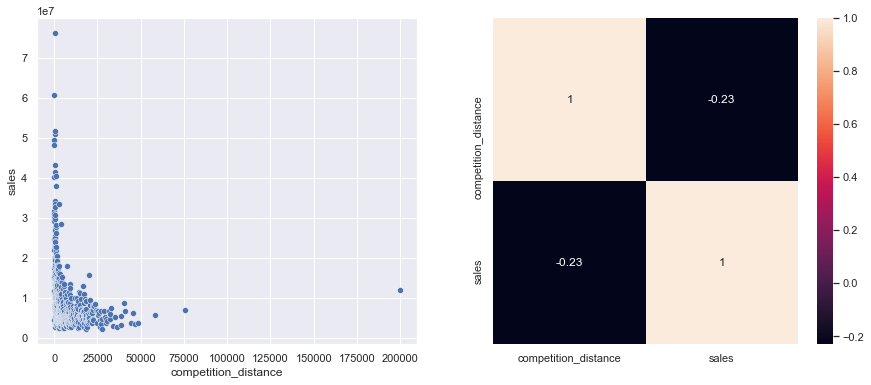

In [49]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1)

plt.subplot(1,2,2);
sns.heatmap(aux1.corr(),annot=True)
plt.show()
                

### H3. Lojas com competidores à mais tempo deveriam vender mais
**falsa:** não, lojas com competidores à mais tempo não vendem mais do que as lojas com competidores abertos mais recentemente

Ao plotar o tempo que o competidor mais próximo está aberto tem-se a distribuição a seguir:

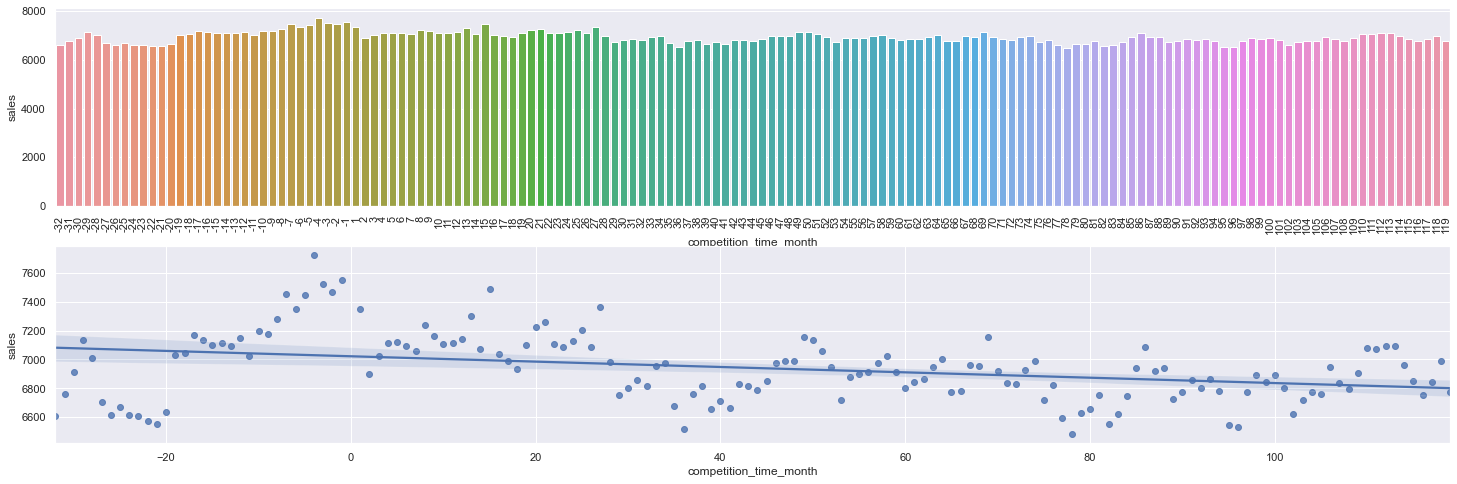

In [50]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.figure(figsize=(25,8))
plt.subplot(2,1,1)
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(2,1,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

Os valores negativos devem-se aos registros de vendas antes do atual competidor mais próximo abrir.
Percebemos que há registros de tendência de maiores vendas meses antes (-12 a -1) dos competidores abrirem.
Ainda, uma vez que o competidor abre, as vendas iniciam uma tendência de queda, não sendo observado nenhuma recuperação significativa até pelo menos os 120 primeiros meses (10 anos) do competidor aberto.
Tal tendência também é sugerida na correlação de Pearson a seguir:

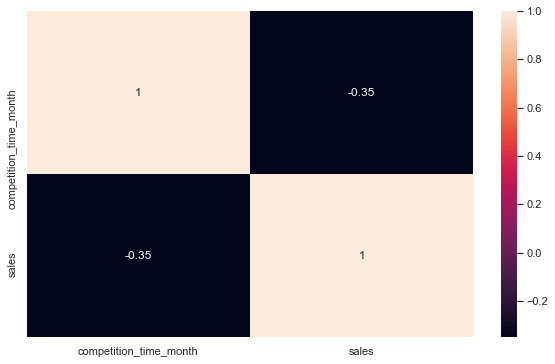

In [51]:
plt.figure(figsize=(10,6))
sns.heatmap(aux2.corr(method='pearson'),annot=True);

O veredito da hipótese H3 é que **"não, lojas com competidores à mais tempo não vendem mais do que as lojas com competidores abertos mais recentemente"**

### H4. Lojas onde os produtos custam menos por mais tempo (promoções ativas) deveriam vender mais
**verdadeira:** sim, lojas onde os produtos custam (ou já custaram) menos por mais tempo tendem a vender mais

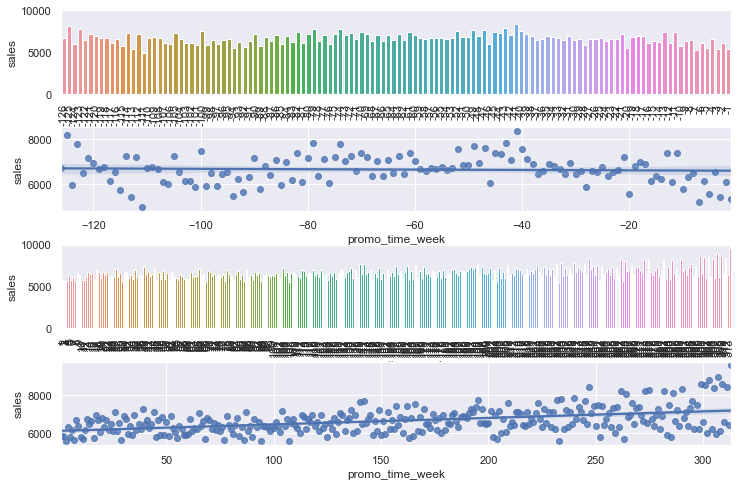

In [52]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').mean().reset_index()

plt.subplot(4,1,1)
aux2 = aux1[aux1['promo_time_week'] < 0] # vendas em lojas que nunca fizeram alguma promoção estendida
plt.xticks(rotation = 90)
plt.ylim(0,10000)
sns.barplot(x='promo_time_week', y='sales', data=aux2);

plt.subplots_adjust(hspace=.4)
plt.subplot(4,1,2)
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplots_adjust(hspace=.4)
plt.subplot(4,1,3)
aux3 = aux1[aux1['promo_time_week'] > 0] # vendas em lojas que já fizeram alguma promoção estendida
plt.xticks(rotation = 90)
plt.ylim(0,10000)
sns.barplot(x='promo_time_week', y='sales', data=aux3);

plt.subplots_adjust(hspace=.4)
plt.subplot(4,1,4)
sns.regplot(x='promo_time_week', y='sales', data=aux3);



Em média, as vendas que ocorreram em lojas que nunca adotaram a promo2 mostraram-se constantes; em contrapartida, as vendas que ocorreram em lojas que já adotaram alguma vez a promo2 apresenta tendência, ainda que tímida, de subida com o passar do tempo. A correlação de Pearson mostrada a seguir complementa a análise:

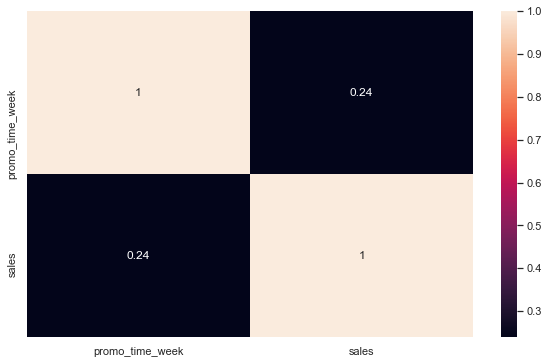

In [53]:
plt.figure(figsize=(10,6))
sns.heatmap(aux1.corr(method='pearson'), annot = True);

O veredito da hipótese H4 é que **"sim, lojas onde os produtos custam (ou já custaram) menos por mais tempo tendem a vender mais"**

### <s> H5. Lojas com mais dias de promoção deveriam vender mais </s>


Como ela é muito parecida com a H4, será avaliada no próximo ciclo do CRISP

### H6. Lojas com mais promoções estendidas deveriam vender mais
**falsa:** "não, lojas que apresentam maior quantidade de promoções estendidas tendem a vender menos, em média, em comparação com lojas que apresentam apenas a promoção tradicional."

In [54]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).mean().reset_index().sort_values(by='sales')

,promo,promo2,sales
1,0,1,5529.566684
0,0,0,6328.187633
3,1,1,7836.672987
2,1,0,8618.452062


Em média, constata-se que as lojas que aderiram à promo1 tendem à vender mais do que a promo2 (que é a promoção estendida). A seguir, será analisado se notamos alguma mudança de comportamento com o tempo.

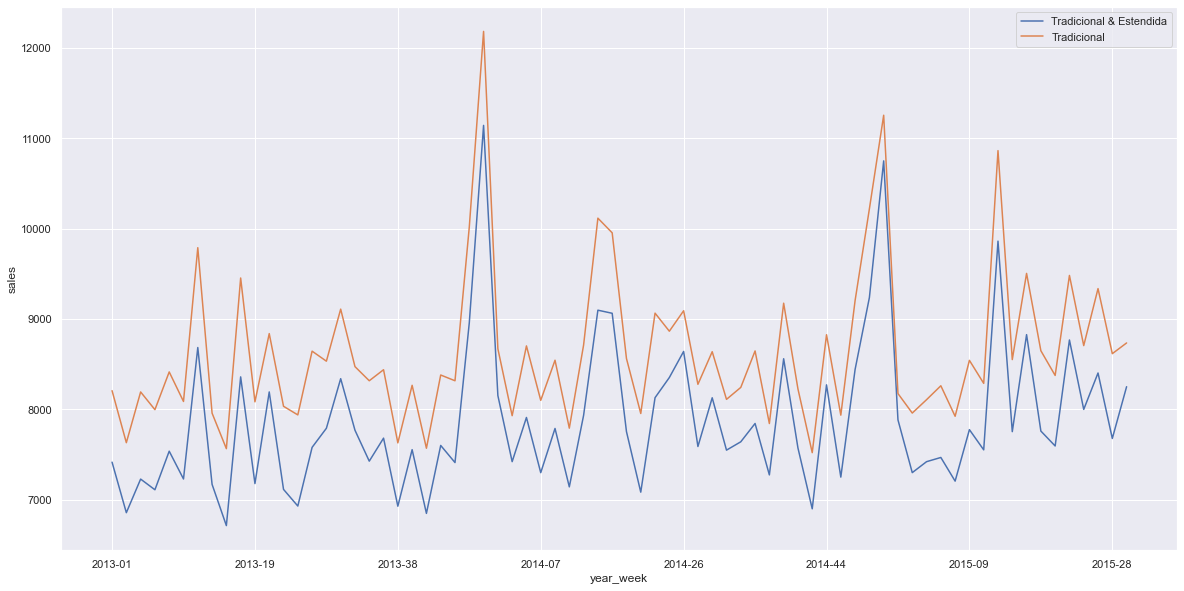

In [55]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux1.set_index('year_week',inplace=True)
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux2.set_index('year_week',inplace=True)
aux2.plot(ax=ax, figsize=(20,10),xlabel='year_week',ylabel='sales')

ax.legend(labels=['Tradicional & Estendida', 'Tradicional'])
plt.show()

O veredito da hipótese H6 é que "não, lojas que apresentam maior quantidade de promoções estendidas tendem a vender menos, em média, em comparação com lojas que apresentam apenas a promoção tradicional."

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais
**verdadeira:**: sim, possivelmente as vendas do Natal são mais expressivas em comparação com as vendas em feriados publicos e dias comuns, apenas perdendo ou empatando com o feriado de Páscoa.

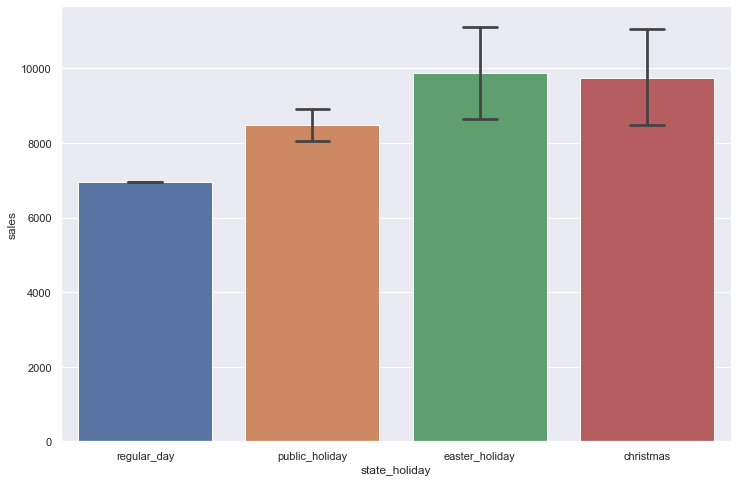

In [56]:
plt.figure(figsize=(12,8))
sns.barplot(x='state_holiday', y='sales', data=df4, estimator = np.mean, capsize=.2)
plt.show()

Nota-se que o feriado de Natal, acompanhado pelo de Páscoa, são os dois feriados onde as vendas, em média, são maiores.
A seguir, será feito análise do longo dos anos.

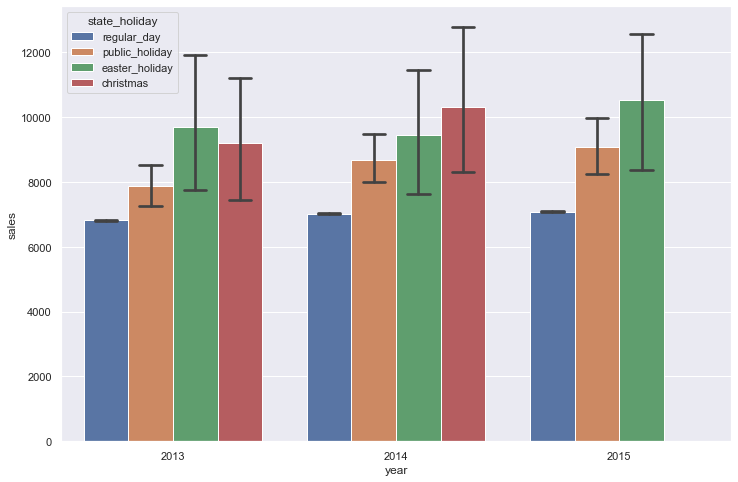

In [57]:
plt.figure(figsize=(12,8))
sns.barplot(x='year', y='sales', hue='state_holiday', data=df4, estimator = np.mean, capsize=.1)
plt.show()

Pela figura acima, aparentemente o Natal de 2014 foi mais expressivo quanto as vendas em relação ao Natal de 2013. E em 2015 é como se o ano estivesse em construção, pois o último dia dos dados é em 31/07/2015, logo antes do Natal.

O veredito da hipótese H7 é que "sim, possivelmente as vendas do Natal são mais expressivas em comparação com as vendas em feriados publicos e dias comuns, apenas perdendo ou empatando com o feriado de Páscoa."

###  H8. Lojas deveriam vender mais ao longo dos anos


**inconclusiva:** por haver apenas dados de 2 anos (2013 e 2014) sendo uma afirmação possível de se escrever é que, em média, as vendas em 2014 foram mais altas do que em 2013".

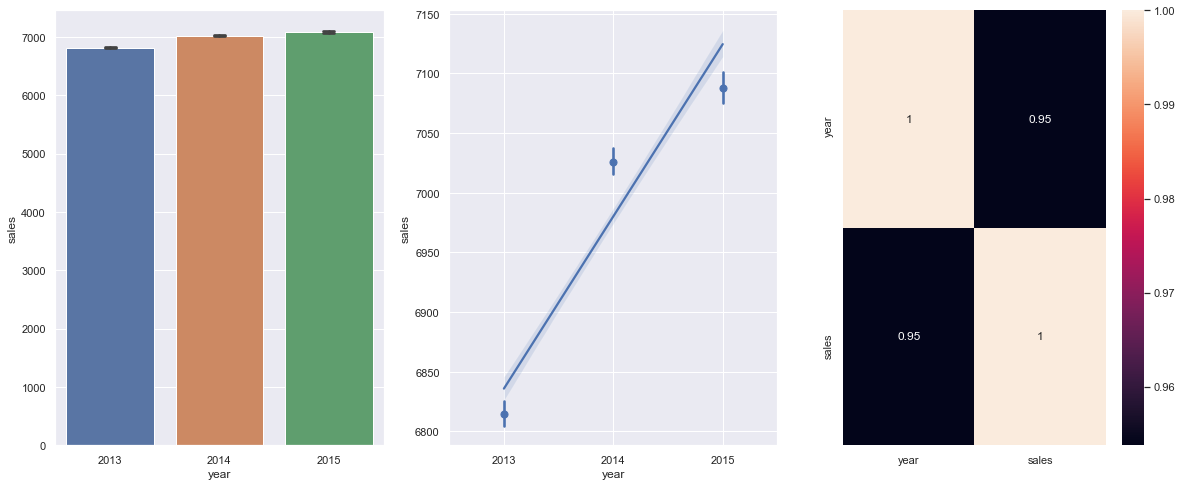

In [58]:
aux1 = df4[['year','sales']].groupby('year').mean().reset_index()

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=df4, estimator = np.mean, capsize=.1)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=df4, x_estimator=np.mean)
plt.xlim(2012.5, 2015.5)
plt.xticks([2013,2014,2015])

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

Há apenas 2 anos com dados de 01/01 à 31/12, que são 2013 e 2014. Portanto essa não é uma análise abrangente; em 2015, a média das vendas não está levando em consideração o segundo semestre. Podemos dizer que em, média, as lojas venderam mais em 2014 em relação à 2013. Ressalta-se ainda que dificilmente esta análise será um insight, visto que as vendas devem ser uma das métricas já acompanhadas pela empresa.

O veredito da hipótese H8 é que é "inconclusivo, por haver apenas dados de 2 anos (2013 e 2014) sendo que uma afirmação é que, em média, as vendas em 2014 foram mais altas do que em 2013".

### H9. Lojas deveriam vender mais no segundo semestre do ano
**falsa:** não é possível afirmar que há mais vendas no segundo semestre; embora a média seja ligeiramente maior, a flutuação é maior


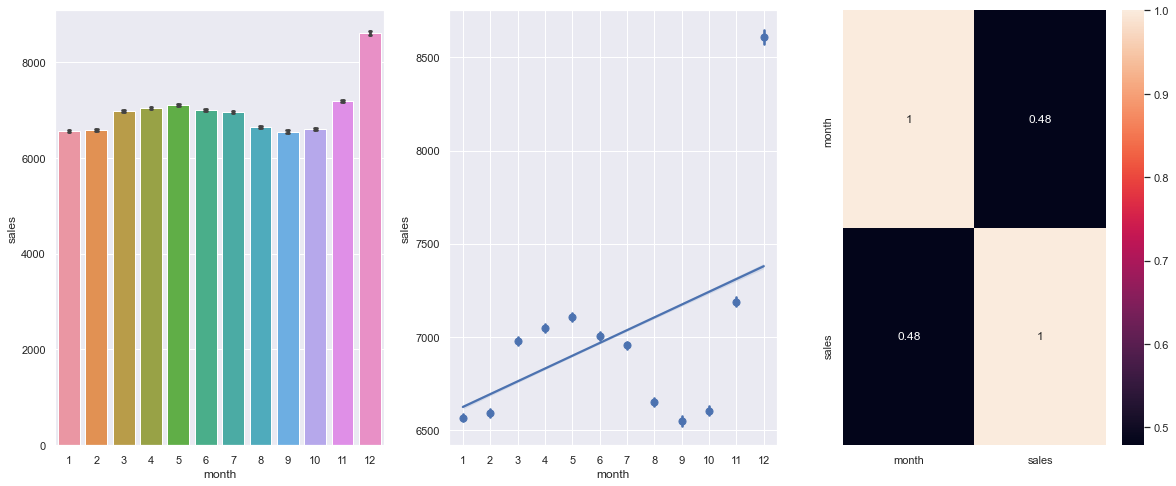

In [59]:
aux1 = df4[['month','sales']].groupby('month').mean().reset_index()

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=df4, estimator = np.mean, capsize=.1)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=df4, x_estimator=np.mean)
plt.xlim(0.5, 12.5)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

Nota-se que o segundo semestre do ano concentram meses com baixa venda (Outubro e Novembro) e meses com altas vendas (Novembro e Dezembro)
Por enquanto é inconclusivo dizer que no segundo semestre vende mais ou menos em relação ao primeiro. Para isso pode-se fazer uma nova análise:

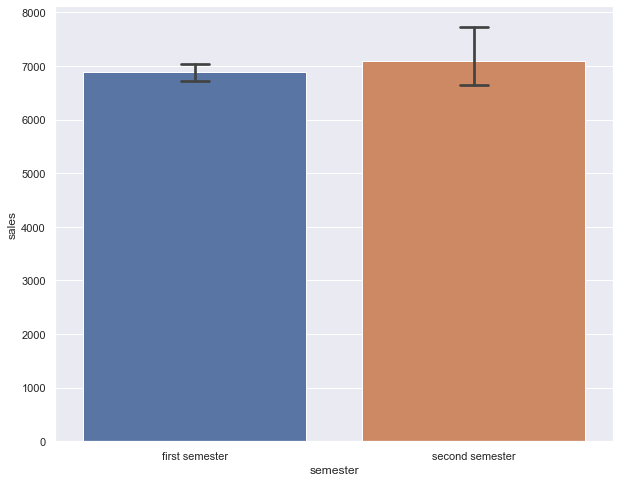

In [60]:
x = lambda x: 'first semester' if x in [1,2,3,4,5,6] else 'second semester'
aux1['semester'] = aux1['month'].apply(x)
plt.figure(figsize=(10,8))
sns.barplot(x='semester', y='sales', data=aux1, estimator = np.mean, capsize=.1)
plt.show()

O veredito da hipótese H9 é que é "falsa, visto que não é possível afirmar que há mais vendas no segundo semestre; embora a média seja ligeiramente maior, a flutuação é maior, conforme comentado previamente".

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês
**falsa:** antes do dia 10 as lojas vendem ligeiramente mais

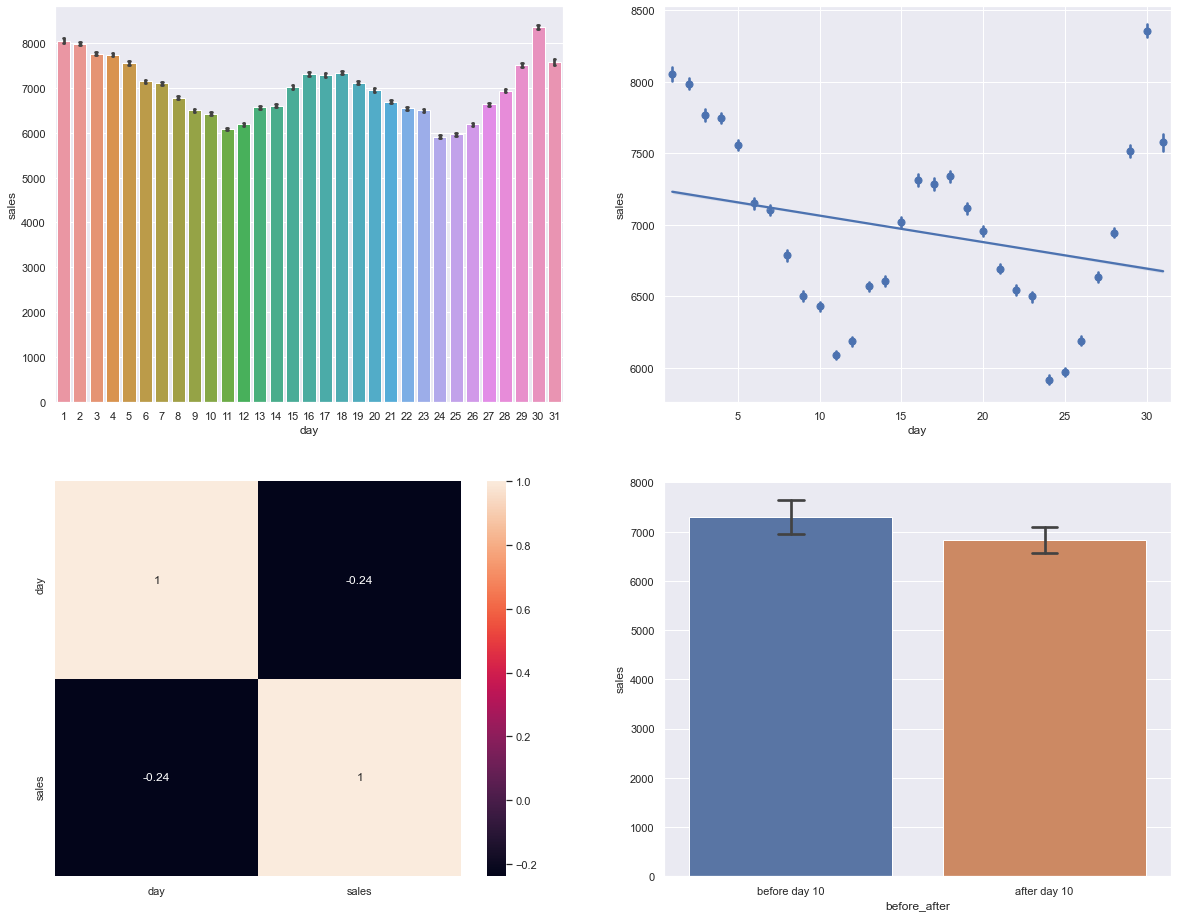

In [61]:
aux1 = df4[['day','sales']].groupby('day').mean().reset_index()

plt.figure(figsize=(20,16))

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=df4, estimator = np.mean, capsize=.1)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=df4, x_estimator=np.mean)
plt.xlim(0.5, 31.5)
plt.xlabel

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


x = lambda x: 'before day 10' if x <= 10 else 'after day 10'
aux1['before_after'] = aux1['day'].apply(x)
plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux1, estimator = np.mean, capsize=.1)


plt.show()

Após analisar a composição dos 4 gráficos desta hipótese, nota-se que antes do dia 10, em média, as lojas vendem mais. Destaque para as vendas a partir do dia primeiro, embora relativamente altas, em queda quase constante até justamente o dia 10. Percebe-se também que as vendas aumentam mais pro final do mês.

O veredito da hipótese H10 é que é "falsa, pois antes do dia 10 as lojas vendem ligeiramente mais"

### H11. Lojas deveriam vender menos aos finais de semana
**verdadeira:** aos finais de semana, no total, as lojas vendem menos

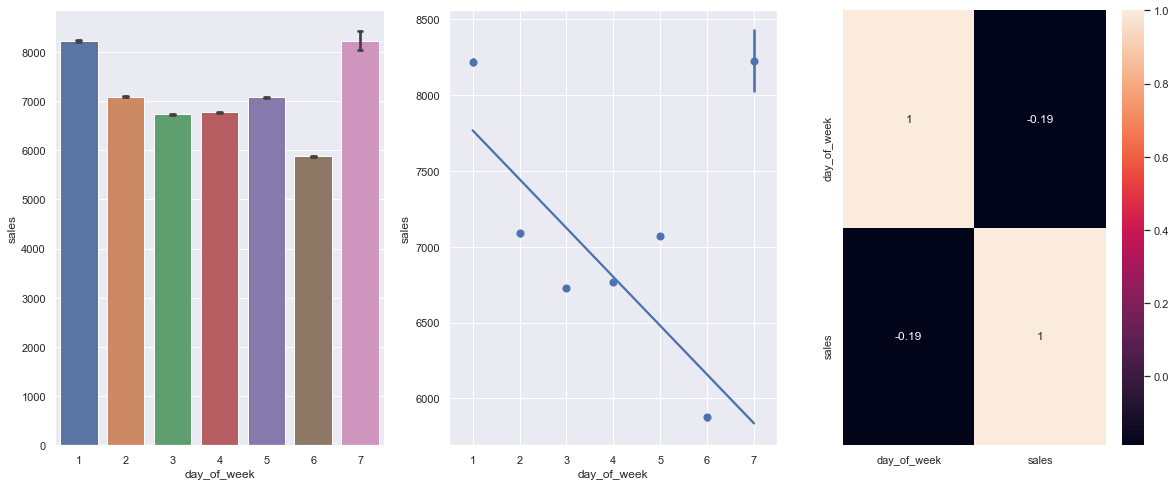

In [62]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').mean().reset_index()

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=df4, estimator = np.mean, capsize=.1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=df4, x_estimator=np.mean)
plt.xlim(0.5, 7.5)


plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

Constata-se que os finais de semana, em média, apresentam vendas menores no sábado e maiores no domingo. Mas se somarmos as contribuições das vendas de todas as lojas, percebemos que os finais de semana representam baixas vendas no total. 

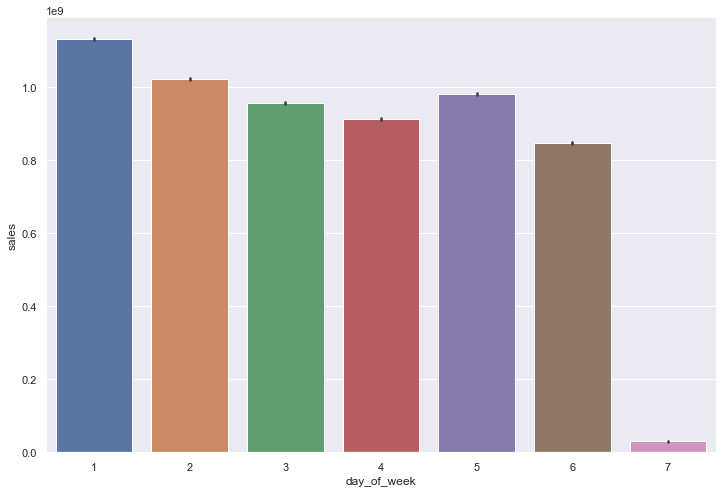

In [63]:
plt.figure(figsize=(12,8))
sns.barplot(x='day_of_week', y='sales', data=df4, estimator = np.sum)
plt.show()

Com isso, também nota-se que, se na média, o domingo é o dia da semana com as maiores vendas, mas no total é o dia que menos vende, muitas lojas não devem abrir aos domingos. Este assunto será tratado na hipótese 13.

O veredito da hipótese H11 é que é "verdadeira, pois aos finais de semana, no total, as lojas vendem menos"

### H12. Lojas deveriam vender menos durante os feriados escolares
**falsa:** nos feriados escolares as lojas vendem mais, exceto em Setembro e Dezembro.

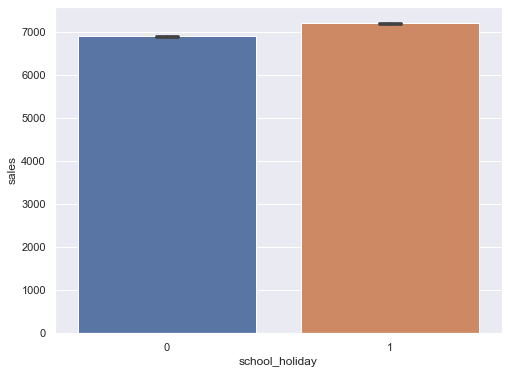

In [64]:
plt.figure(figsize=(8,6))
sns.barplot(x='school_holiday', y='sales', data=df4, estimator = np.mean, capsize=.1);

Com a análise do gráfico acima, percebe-se que nos feriados escolares, em média, vende-se mais; a seguir será feito uma análise por mês.

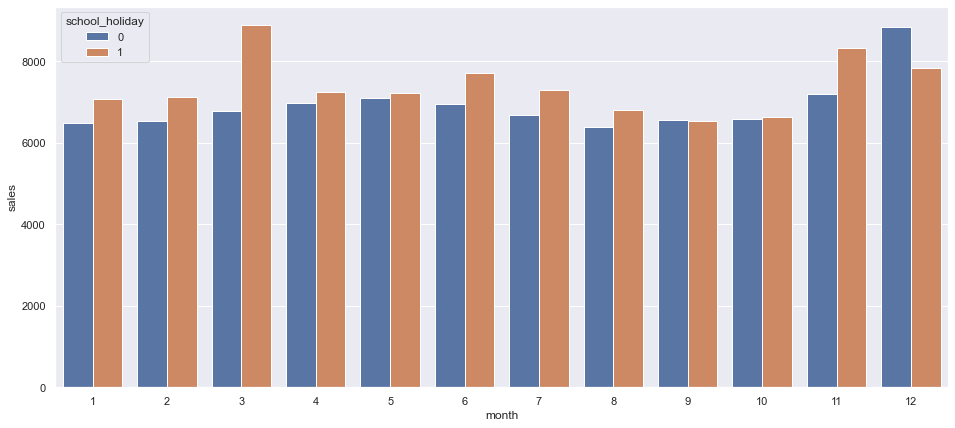

In [65]:
plt.figure(figsize=(16,7))
aux1 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).mean().reset_index()
sns.barplot(x='month', y = 'sales', hue='school_holiday', data = aux1);

Nota-se que, com exceção dos meses de Setembro e Dezembro, em média vende-se mais nos feriados escolares. Destaque para as vendas dos feriados escolares de Março e Novembro.

O veredito da hipótese H12 é que é "falsa, pois nos feriados escolares as lojas vendem mais"

### H13. (extra) Lojas que abrem aos <s> finais de semana</s> domingos deveriam vender mais
**verdadeira:** lojas que abrem aos domingos vendem mais

Esta é uma hipótese extra que surgiu após a conclusão da hipótese 11. Primeiramente, há de se verificar a quantidade de lojas que abrem em cada dia da semana.

In [66]:
df4[['day_of_week','store']].groupby('day_of_week').nunique()

,store
day_of_week,
1,1115
2,1115
3,1115
4,1115
5,1115
6,1115
7,33


Após a análise da hipótese 11, o domingo é o único dia que menos lojas abrem, apenas 33. Portanto, o nome dessa hipótese deverá mudar: "Lojas que abrem aos <s> finais de semana</s> domingos deveriam vender mais."

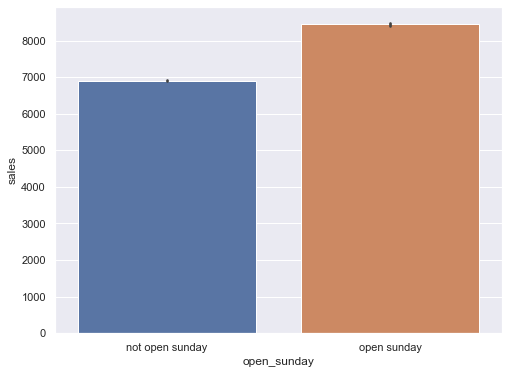

In [67]:
# captura as lojas que abrem aos domingos
stores_open_sunday = list(df4[df4['day_of_week']==7]['store'].unique())

x = lambda x: 'open sunday' if x in stores_open_sunday else 'not open sunday'
aux1 = df4[['store','sales','day_of_week']].copy()
aux1['open_sunday'] = aux1['store'].apply(x)

plt.figure(figsize=(8,6))
sns.barplot(x='open_sunday', y='sales', data=aux1, estimator = np.mean)
plt.show()

Após a análise do gráfico anterior, pode-se dizer que aquelas lojas que abrem aos domingos vendem, em média, mais do que as lojas que não abrem aos domingo. Mas para ser mais justo na comparação, deve-se excluir as vendas do domingo, assim as lojas que abrem aos domingos terão o desempenho de suas vendas de segunda à sábado comparado com as vendas das lojas que não abrem aos domingos.

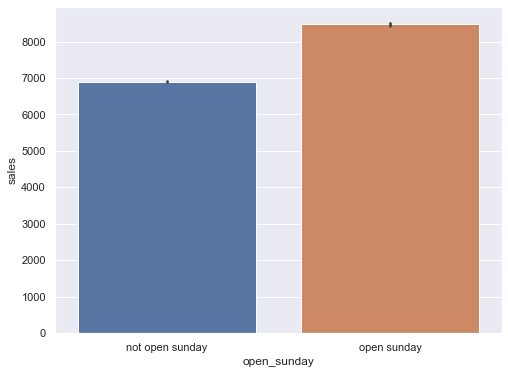

In [68]:
aux2 = aux1[aux1['day_of_week'] != 7]
plt.figure(figsize=(8,6))
sns.barplot(x='open_sunday', y='sales', data=aux2, estimator = np.mean)
plt.show()

Mesmo excluindo-se as vendas de domingo, as lojas que costumam abrir nesse dia da semana apresentam um desempenho superior em relação as lojas que não abrem aos domingos.

O veredito da hipótese H13 é que é "verdadeira, pois lojas que abrem aos domingos vendem mais".

### 4.2.1 Resumo das hipóteses

In [69]:
from tabulate import tabulate

tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1 - lojas com maior sortimento deveriam vender mais', 'verdadeira','média'],
       ['H2 - lojas com competidores mais próximos deveriam vender menos', 'falsa','baixa'],
       ['H3 - lojas com competidores à mais tempo deveriam vender mais','falsa','média'],
       ['H4 - lojas onde os produtos custam menos por mais tempo (promoções ativas) deveriam vender mais', 'verdadeira','baixa'],
       ['H5 - lojas com mais dias de promoção deveriam vender mais', 'não avaliada', '-'],
       ['H6 - lojas com mais promoções estendidas deveriam vender mais','falsa', 'alta'],
       ['H7 - lojas abertas durante o feriado de Natal deveriam vender mais', 'verdadeira', 'alta'],
       ['H8 - lojas deveriam vender mais ao longo dos anos','inconclusiva','alta*'],
       ['H9 - lojas deveriam vender mais no segundo semestre do ano', 'falsa', 'média'],
       ['H10 - lojas deveriam vender mais depois do dia 10 de cada mês', 'falsa', 'alta'],
       ['H11 - lojas deveriam vender menos aos finais de semana','verdadeira','alta'],
       ['H12 - lojas deveriam vender menos durante os feriados escolares', 'falsa', 'alta'],
       ['H13 - lojas que abrem aos domingos deveriam vender mais', 'verdadeira','alta'],       
      ]

print(tabulate(tab, headers='firstrow', tablefmt="fancy_grid"))
print("*embora a H8 foi inconclusiva, considero de alta relevância a variável 'ano' para o modelo de Machine Learning")

╒═════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════╤══════════════╕
│ Hipóteses                                                                                       │ Conclusão    │ Relevância   │
╞═════════════════════════════════════════════════════════════════════════════════════════════════╪══════════════╪══════════════╡
│ H1 - lojas com maior sortimento deveriam vender mais                                            │ verdadeira   │ média        │
├─────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────┼──────────────┤
│ H2 - lojas com competidores mais próximos deveriam vender menos                                 │ falsa        │ baixa        │
├─────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────┼──────────────┤
│ H3 - lojas com competidores à mais tempo deveriam vender mais                           

## 4.3 Análise multivariada

### 4.3.1. Numerical attributes

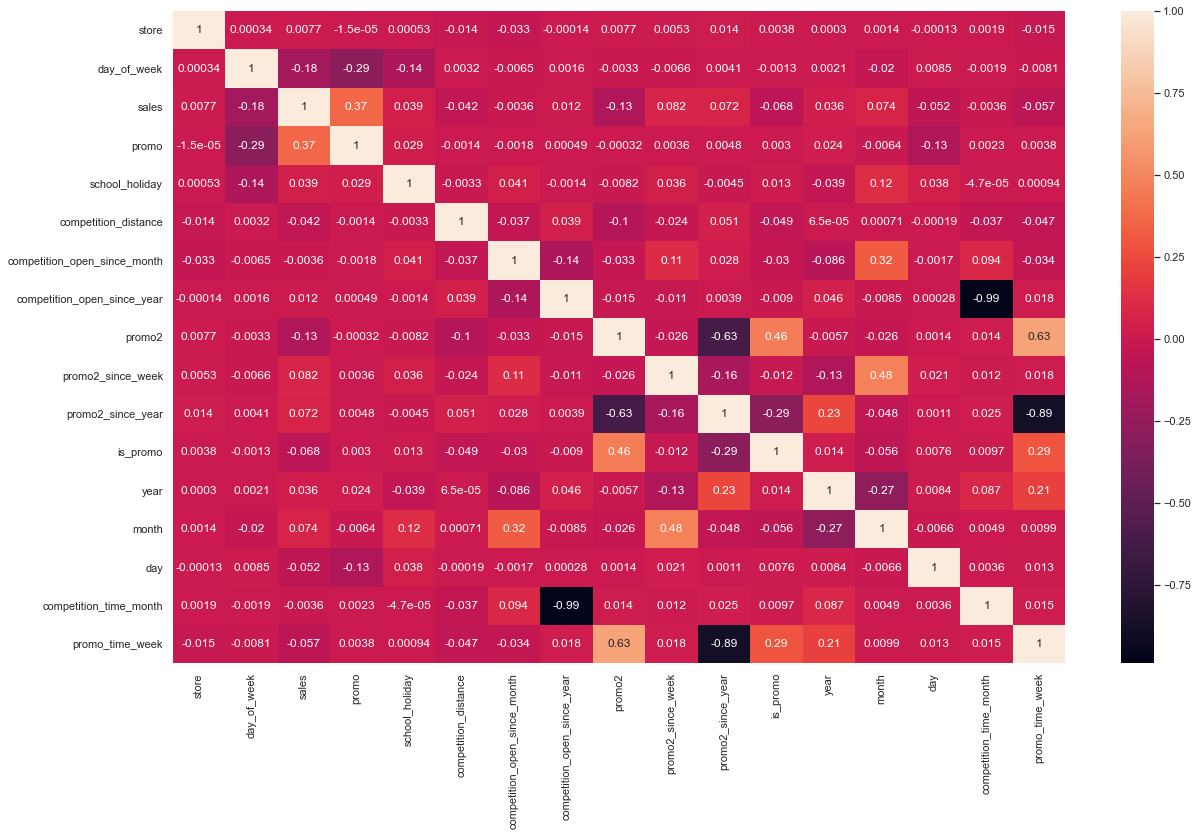

In [70]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(20,12))
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical attributes

Nesta seção é feita a análise de correção das variáveis categóricas seguindo o método de Cramér's V (https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V <br>
A função foi definida na seção 0.1.

In [71]:
# seleciona apenas as colunas do tipo 'objet'
a = df4.select_dtypes(include='object')

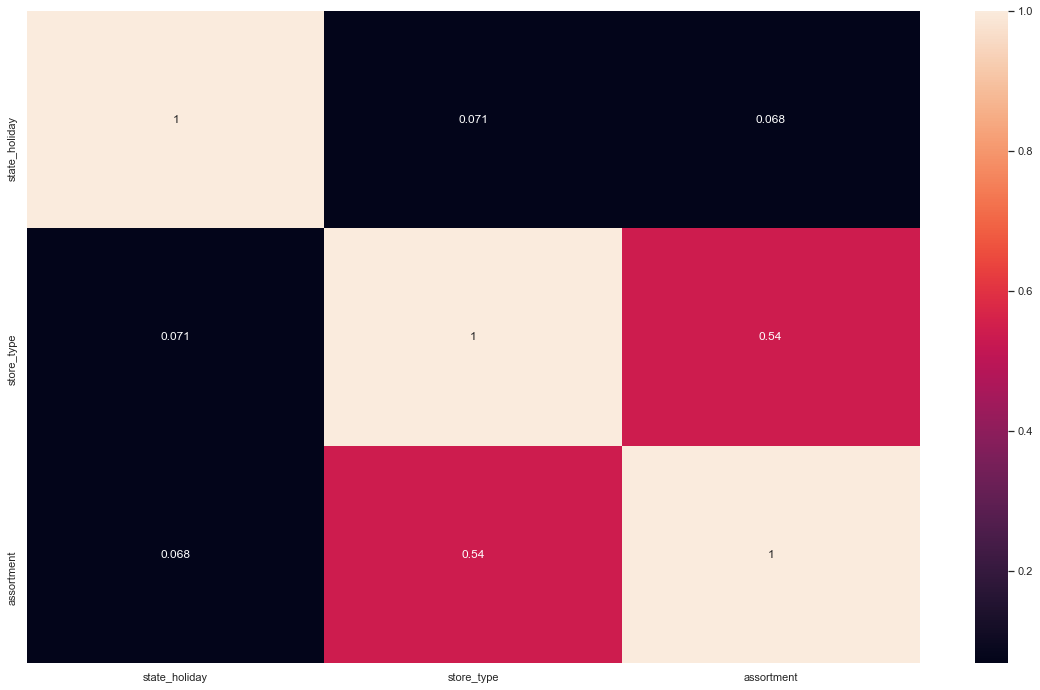

In [72]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# dataset final
d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9]          
             })

d = d.set_index(d.columns)
plt.figure(figsize=(20,12))
sns.heatmap(d,annot=True);

Nota-se que as variáveis 'store_type' e 'assortment' possuem razoável correlação.

# 5. PREPARAÇÃO DOS DADOS

Nesta seção inicia-se a modelagem dos dados, que envolve a preparação dos dados e o filtro das variáveis mais relevantes para o aprendizado do modelo.

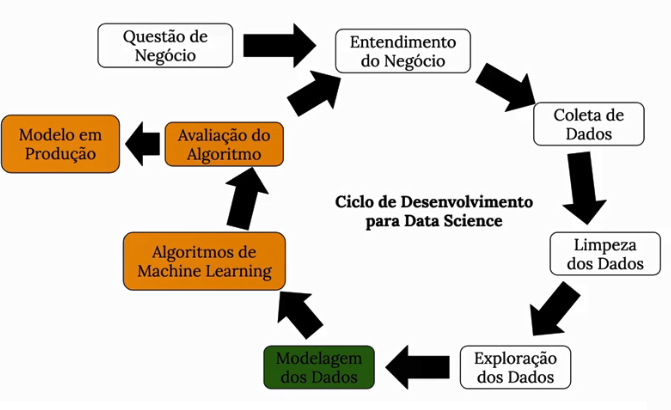

In [73]:
Image("img/crisp2.png")

O aprendizado da maioria dos algoritmos de machine learning é facilitado com dados numéricos, na mesma escala. As próximas subseções são dedicadas para transformar todas as variáveis na mesma ordem de grandeza.

In [146]:
df5 = df4.copy()

## 5.1. Normalização

Após consultar a seção 4.1.2 nota-se que não há nenhuma distribuição normal. Sendo assim, não será aplicada a normalização (que seria centralizar em 0 e ajustar o desvio padrão para 1) de nenhuma série de dados.

## 5.2. Rescaling

In [147]:
# originalmente a series 'week_of_year' está como tipo UInt32; faz-se a conversão.
df5['week_of_year'] = df5['week_of_year'].astype(np.int64)

In [148]:
df5.select_dtypes(include=['int32','int64','float64']).columns

Index(['store', 'day_of_week', 'sales', 'promo', 'school_holiday',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'month', 'day', 'week_of_year',
       'competition_time_month', 'promo_time_week'],
      dtype='object')

As 4 variáveis (não cíclicas) onde será feito o rescaling são:
- 'competition_distance'
- 'year'
- 'competition_time_month'
- 'promo_time_week'

A escolha entre MinMaxScaler ou RobustScaler é se elas têm ou não outliers

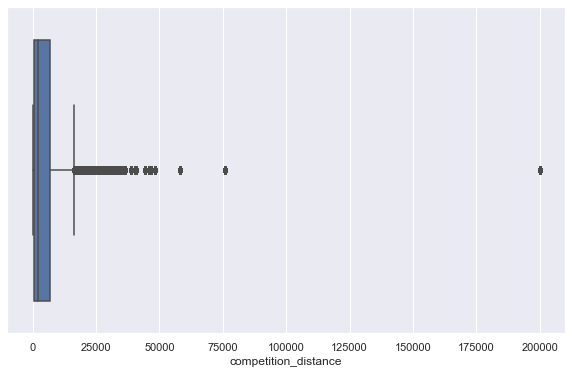

In [149]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['competition_distance']);

Na seção 1.5 foram inseridos outliers para o valor de 200k, em substituição aos valores faltantes; foi uma maneira de sinalizar que os competidores mais próximos, para as lojas onde esse valor era nan, na verdade estão muito distantes.
Para esta variável será feito rescalign usando o RobustScalerplt.figure(figsize=(12,8))
sns.boxplot(x = df5['competition_distance']);

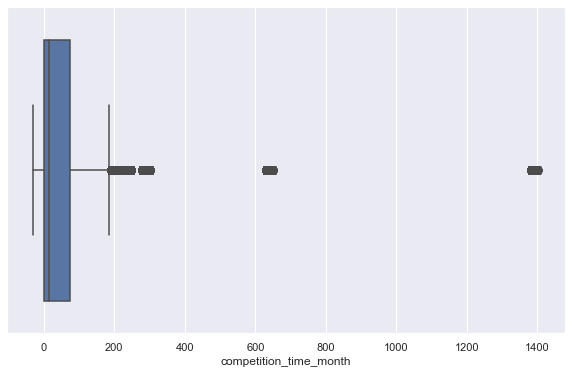

In [150]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['competition_time_month']);

Também há muitos outliers na 'competition_time_month'. Será usado o RobustScaler.

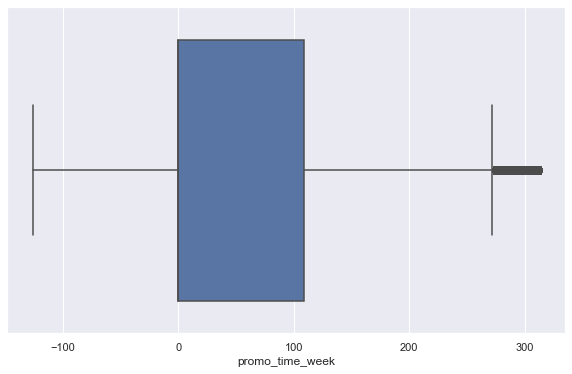

In [151]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['promo_time_week']);

Para esta variável, os outliers não são tão relevantes; será usado o MinMaxScaler.

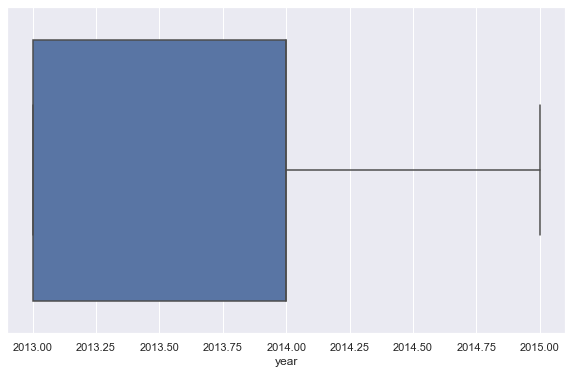

In [152]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['year']);

Não há outliers para o ano; será usado o MinMaxScaler.

In [163]:
rs = RobustScaler()
mms = MinMaxScaler()

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
# salvar o scaler utilizado para utilizar na produção
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl','wb'))

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
# salvar o scaler utilizado para utilizar na produção
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl','wb'))

df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
# salvar o scaler utilizado para utilizar na produção
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl','wb'))

df5['year'] = mms.fit_transform(df5[['year']].values)
# salvar o scaler utilizado para utilizar na produção
pickle.dump(mms, open('parameter/year_scaler.pkl','wb'))

# para o próximo ciclo do CRISP rescalar as variáveis 'promo2_since_week', 'promo2_since_year' e 'competition_open_since_year'


## 5.3. Transformação

### 5.3.1 Encoding

As 3 variáveis (não cíclicas) onde será feito o encoding são:
- 'state_holiday'
- 'store_type'
- 'assortment'

In [155]:
# one hot encoding: funciona muito bem para 'estados', como a 'vendas ocorrendo em feriado ou não'
df5 = pd.get_dummies(data=df5,prefix='state_holiday',columns=['state_holiday'])

# label_encoding: não sabemos se a informação presente no store_type tem alguma relação ou se são apenas rótulos
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
# salvar o encoder utilizado para utilizar na produção
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))


# ordinal encoding: os tipos de assortment possuem ordem: basic < extra < extendend 
assortment_dict = {'basic':1, 'extra':2, 'extended':3} 
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Transformação da variável alvo

In [84]:
df5['sales'] = np.log1p(df5['sales'])

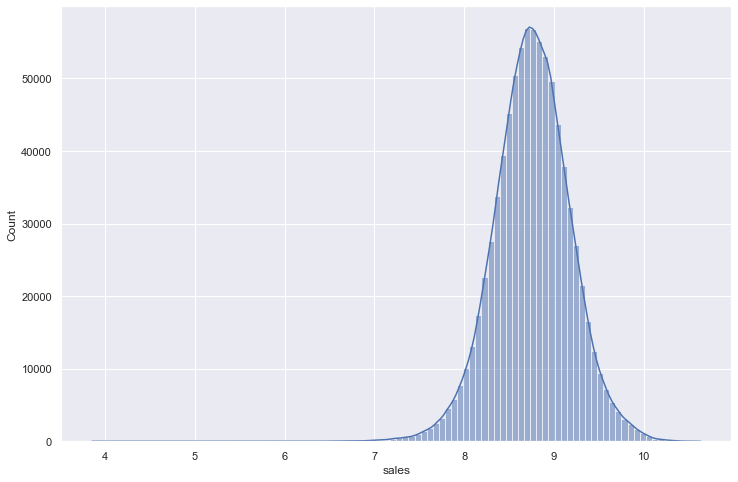

In [85]:
sns.histplot(x = df5['sales'],bins=100,kde = True);

### 5.3.3 Transformação de natureza

Para representarmos a natureza cíclica de variáveis, como "meses do ano" ou "semana do ano" podemos quebrar a variável em duas outras, seno e cosseno. <br> Mais informações:
https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca

In [86]:
#month
df5['month_sin'] = df5['month'].apply(lambda x : np.sin(x * (2 * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x : np.cos(x * (2 * np.pi / 12)))


#day
# fiz a divisão mês a mês (dependendo do último dia do mês), enquanto o prof indicou dividir por 30.
# achei arriscado pois nos meses que tem 31, haverá a divisão "31/30", que vai dar mais de 2pi, que terá um valor muito próximo (ou até maior) que o dia 1
# criar um dicionário com os meses e as re4spectivas quantidades de dias
max_days_month = df5.groupby('month')['day'].max().to_dict()

# nova coluna para registrar o valor do dia máximo daquele mês
df5['max_days_month'] = df5['month'].map(max_days_month)

x = lambda x: np.sin(x['day'] * (2 * np.pi / x['max_days_month']))
df5['day_sin'] = df5.apply(x, axis=1)

x = lambda x: np.cos(x['day'] * (2 * np.pi / x['max_days_month']))
df5['day_cos'] = df5.apply(x, axis=1)

# uma vez que a coluna foi usada nos cálculos acima, pode-se descartá-la
df5.drop(columns='max_days_month',inplace=True)


#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x : np.sin(x * (2 * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x : np.cos(x * (2 * np.pi / 52)))

#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x : np.sin(x * (2 * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x : np.cos(x * (2 * np.pi / 7)))

Plot com a variável de natureza cíclica. Repare que o início e o fim de cada mês são próximos.

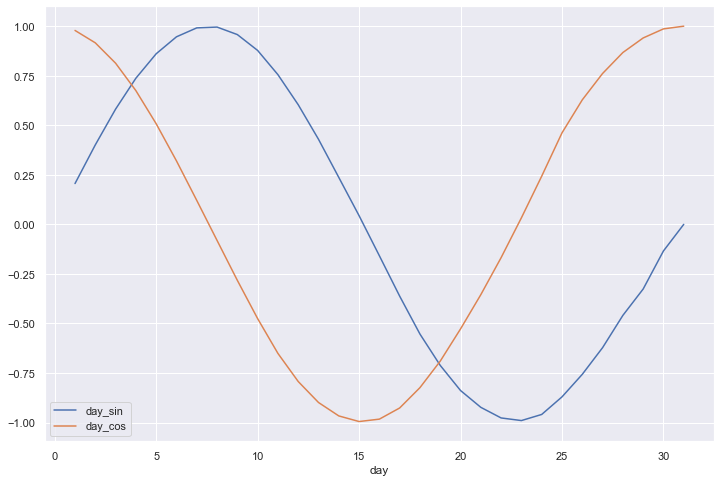

In [87]:
df5[['day','day_sin','day_cos']].groupby('day').mean().plot();

# 6. SELEÇÃO DE VARIÁVEIS

"A explicação mais simples sobre um fenômeno observado deveria prevalecer sobre explicações mais complexas" (Occam's Razor)

In [88]:
df6 = df5.copy()

# excluir features que já foram utilizadas para derivar outras mas que agora não são mais importantes
cols_drop = ['day','month','week_of_year','day_of_week', 'promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis = 1)

## 6.1 Split dataframe into training and test dataset

As últimas 6 semanas serão os dados de treino e depois serão os dados de teste.

In [89]:
df6[['store','date']].groupby('store').min().value_counts()

date      
2013-01-02    1094
2013-01-01      17
2013-07-05       2
2013-01-19       1
2013-04-12       1
dtype: int64

In [90]:
df6[['store','date']].groupby('store').max().value_counts()

date      
2015-07-31    1113
2015-07-10       1
2015-07-15       1
dtype: int64

As vendas iniciaram quase todas em 02/01/2013 e o último registro de vendas para quase todas as lojas é 31/07/2015. <br>
É bastante razoável que o período de 6 semanas para a previsão seja aquele que antecede o dia 31/07/2015. <br>
Se for necessário, na segunda rodada do CRISP removo as lojas que terminaram as vendas em 10/07 e 15/07 (uma de para cada data).

In [91]:
# subtrair 6 semanas (6 * 7 dias)
df6[['store','date']].groupby('store').max().reset_index()['date'][0]- datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

Agora sabe-se que o período de 6 semanas que antecedeu o último registro das vendas iniciou-se em 19/06/2015. Portanto, será utilizado essa data como limite para a separação do dataset em treino e teste.

In [92]:
# training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# test dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print(f"Training min date: {x_train['date'].min()}")
print(f"Training max date: {x_train['date'].max()}")

print(f"\nTest min date: {x_test['date'].min()}")
print(f"Test max date: {x_test['date'].max()}")

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


## 6.2 Boruta as feature selector
(após rodar uma vez, não é necessário rodar novamente - o tempo de processamento é longo e o resultado obtido não deve variar significativamente ao mudar o seed)

In [93]:
### training and test dataset for Boruta
# x_train_n = x_train.drop(columns = ['date', 'sales'], axis =1).values
# y_train_n = y_train.values.ravel()

### define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

### define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state = 42).fit(x_train_n, y_train_n)

#cols_selected = boruta.support_.tolist()

### como o x_train ainda possui as features 'date' e 'sales', preciso removê-las para preservar a mesma sequência de colunas do x_train_n (que é só um vetor)
#x_train_fs = x_train.drop(['date','sales'],axis=1)

### a linha abaixo seleciona, baseado na variável cols_selected, obtida da saída 'support_' do Boruta, que é um vetor de True e False para cada uma das colunas
#cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

### colunas não selecionadas
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))



### último tempo de execução: 50m 2.73s

### 6.2.1 Best features from Boruta

In [94]:
cols_not_selected_boruta = ['is_promo','month_sin', 'school_holiday', 'state_holiday_christmas', 'state_holiday_easter_holiday', 
                            'state_holiday_public_holiday', 'state_holiday_regular_day', 'week_of_year_sin', 'year']

cols_selected_boruta = ['store','promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                        'promo_time_week', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']

### 6.2.2 Atualização da tabela de hipóteses e considerações para o próximo ciclo do CRISP

In [95]:
from tabulate import tabulate

tab = [['hipóteses', 'conclusão', 'relevância', 'variável chave','boruta'],
       ['H1 - lojas com maior sortimento deveriam vender mais', 'verdadeira','média','assortment','selecionou'],
       ['H2 - lojas com competidores mais próximos deveriam vender menos', 'falsa','baixa','competition_distance','selecionou'],
       ['H3 - lojas com competidores à mais tempo deveriam vender mais','falsa','média','competition_time_month','selecionou'],
       ['H4 - lojas onde os produtos custam menos por mais tempo (promoções ativas) deveriam vender mais', 'verdadeira','baixa','promo_time_week','selecionou'],
       ['H5 - lojas com mais dias de promoção deveriam vender mais', 'não avaliada', '-','-','-'],
       ['H6 - lojas com mais promoções estendidas deveriam vender mais','falsa', 'alta','promo e promo2','selecionou'],
       ['H7 - lojas abertas durante o feriado de Natal deveriam vender mais', 'verdadeira', 'alta','state_holiday','descartou'],
       ['H8 - lojas deveriam vender mais ao longo dos anos','inconclusiva','alta*','year','descartou'],
       ['H9 - lojas deveriam vender mais no segundo semestre do ano', 'falsa', 'média','month','parcial (month_cos selecionou e month_sin descartou)'],
       ['H10 - lojas deveriam vender mais depois do dia 10 de cada mês', 'falsa', 'alta','day','selecionou'],
       ['H11 - lojas deveriam vender menos aos finais de semana','verdadeira','alta','day_of_week','selecionou'],
       ['H12 - lojas deveriam vender menos durante os feriados escolares', 'falsa', 'alta','school_holiday','descartou'],
       ['H13 - lojas que abrem aos domingos deveriam vender mais', 'verdadeira','alta','day_of_week','selecionou'],       
      ]

print(tabulate(tab, headers='firstrow', tablefmt="fancy_grid"))
print("*embora a H8 foi inconclusiva, considero de alta relevância a variável 'ano' para o modelo de Machine Learning")

╒═════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════╤══════════════╤════════════════════════╤══════════════════════════════════════════════════════╕
│ hipóteses                                                                                       │ conclusão    │ relevância   │ variável chave         │ boruta                                               │
╞═════════════════════════════════════════════════════════════════════════════════════════════════╪══════════════╪══════════════╪════════════════════════╪══════════════════════════════════════════════════════╡
│ H1 - lojas com maior sortimento deveriam vender mais                                            │ verdadeira   │ média        │ assortment             │ selecionou                                           │
├─────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────┼──────────────┼────────────────────────┼──────

<br>
Constata-se que:
<ul>
<li>2 hipóteses cuja variável chave eu havia considerado de baixa relevância para o modelo ('competition_distance' e 'promo_time_week'), o Boruta considerou elas como importantes;</li><br>
<li>3 hipóteses cuja variável chave eu havia considerado de média relevância para o modelo ('assortment, 'competition_time_month' e 'month'*), o Boruta considerou elas como importantes;</li>
<ul>
*'month' o Boruta considerou parcialmente
</ul><br>

<li>4 hipóteses cuja variável chave eu havia considerado de alta relevância para o modelo ('promo e promo2', 'day' e 'day_of_week'), o Boruta considerou elas como importantes;</li><br>
<li>3 hipóteses cuja variável chave eu havia considerado de alta relevância para o modelo ('state_holiday, 'year' e 'school_holiday'), o Boruta não considerou elas como importantes. </li>

Uma possível explicação para as variáveis dos feriados não terem sido consideradas pelo Boruta é que tais feriados podem influenciar as vendas durante a semana como um todo, incluindo o próprio dia do feriado. No próximo ciclo do CRISP será criada uma hipótese nova: "Lojas devem vender mais durante a semana dos feriados", cuja variável chave é a 'week_of_year', selecionada pelo modelo.

Outra variável selecionada pelo Boruta é a 'store_type'; como não está claro o que significa cada um desses tipos de lojas (a base de dados só forneceu letras, de 'a' até 'd'), não foi utilizada durante as validações de hipóteses na análise bivariada. Entretanto, verificou-se, durante a análise multivariada dos atributos categóricos que ela possui relativa forte correlação com o 'assortment', que foi selecionado.

Por fim, a variável 'is_promo', derivada na seção 1.5, cujo valor é 1 (quando a venda refere-se ao mês do início da promo2) ou 0 (quando a venda ocorreu em um mês diferente do inicial da promo2) parece não ter relevância na predição das vendas. Ao revisitar a derivação dessa variável, constata-se qe foi cometido um erro de análise: ao atribuir 'is_promo = 1' apenas como base na existência do mês da venda na variável (já descartada no atual dataset) 'promo_interval', há atribuição no passado da loja, ainda antes dela aderir pela primeira vez à promo2.
O exemplo abaixo, resgatado da df1 mostra que a loja 620 iniciou a promo2 na semana 40 de 2014, iniciando-se em Jan, Abr, Jul e Out. Para as vendas ocorridas em Julho de 2013 não existia a promo2 ainda, entretanto erroneamente foi atribuído o valor '1' para 'is_promo'.

In [96]:
df1.loc[799289]

store                                           620
day_of_week                                       1
date                            2013-07-15 00:00:00
sales                                          9732
customers                                       866
open                                              1
promo                                             1
state_holiday                                     0
school_holiday                                    0
store_type                                        d
assortment                                        c
competition_distance                         5440.0
competition_open_since_month                      7
competition_open_since_year                    2013
promo2                                            1
promo2_since_week                                40
promo2_since_year                              2014
promo_interval                      Jan,Apr,Jul,Oct
month_map                                       Jul
is_promo    

Com isso, levanta-se 2 pontos importantes:
<li> a cada gateway no projeto de DS é mesmo muito importante criar uma cópia do df
<li> o próximo ciclo do CRISP terá uma atualização na atribuição do valor para a variável 'is_promo' para não atribuir '1' no passado da loja, enquanto ainda não existia a promo2. Com isso, talvez até mude a análise do Boruta para esta variável.

## 6.2 Manual feature selection

Mesmo o Boruta não considerando inicialmente as variáveis 'month_sin' e'week_of_year_sin', por elas serem complementares às variáveis 'month_cos' e 'week_of_year_cos', elas serão adicionadas no grupo das variáveis selecionadas pelo Boruta.

Além disso, também serão adicionadas as variáveis 'date' e 'sales' para compôr o dataset para as próximas seções (ambas variáveis usadas da divisão de treino e teste na etapa de machine learning)

In [97]:
cols_not_selected_boruta = ['is_promo','month_sin', 'school_holiday', 'state_holiday_christmas', 'state_holiday_easter_holiday', 
                            'state_holiday_public_holiday', 'state_holiday_regular_day', 'week_of_year_sin', 'year']

cols_selected_boruta = ['store','promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                        'promo_time_week', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']


# adiciona 'month_sin' e 'week_of_year_sin' (inicialmente o Boruta deixou ambas de fora) nesse primeiro ciclo do CRISP

cols_selected_boruta_with_extra = ['store','promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                                   'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                                   'promo_time_week','month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin','week_of_year_cos', 
                                   'day_of_week_sin', 'day_of_week_cos']


# 7. MACHINE LEARNING MODELING

Nesta seção inicia-se a modelagem por machine learning. <br>
Com exceção do modelo de média, também será feita a validação cruzada (corss validation) do modelo em sua subseção. A explicação sobre cross validation aplicada em séries temporais e o resumo da performance de todos os modelos está presente na seção 7.6.

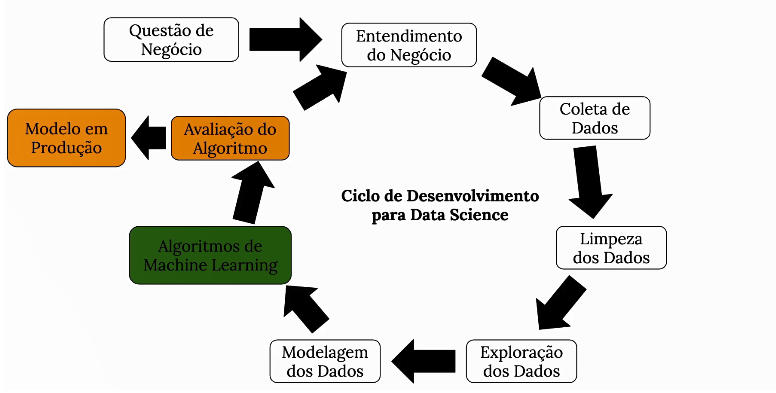

In [98]:
Image("img/crisp3.png")

In [99]:
# training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# test dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test.set_index('store')['sales']

# adicionar 'date' e 'sales' para consolidar a base de treino que será usada no cross-validation
training_set = x_train[cols_selected_boruta_with_extra + ['date','sales']]
test_set = x_test[cols_selected_boruta_with_extra + ['date','sales']]

# atualização das variáveis de treino e teste apenas com as colunas selecionadas pelo Boruta, sem as colunas 'date' e 'sales'
x_train = x_train[cols_selected_boruta_with_extra]
x_test = x_test[cols_selected_boruta_with_extra]

## 7.1. Modelo de média

In [100]:
aux0 = x_train.copy()
aux0['sales'] = y_train.values

aux1 = x_test.copy()

# prediction
aux2 = aux0[['store','sales']].groupby('store').mean().reset_index().rename(columns = {'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')

# para o cálculo manual do MAPE, é importante que ambas as series (a real e a prevista) tenham o mesmo índice 
aux1.set_index('store',inplace=True)
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Modelo de média', np.expm1(y_test),np.expm1(yhat_baseline))
baseline_result

# a divisão entre MAPE_manual e MAPE_sklearn foi necessária pois inicialmente elas estavam resultando em valores diferente.
# após investigar, constatei que o índice das duas pd.series  (y_test e y_hat) estavam descasados, 
# no caso, o y_test pulava o índice se o registro de venda determinada loja não existia e o y_hat não pulava, pois ele é resultado do merge do aux1 com aux2.
# assim, a operação matemática se distorcia totalmente.


,MAE,MAPE_manual,MAPE_sklearn,RMSE
Modelo de média,1429.763326,0.216814,0.216814,1939.32873


## 7.2. Regressão linear
Regressão linear (não regularizada) produz modelos lineares que minimizam a soma de erros quadrados entre os valores reais e previstos da variável de destino dados de treinamento.
https://help.alteryx.com/pt-br/current/designer/linear-regression-tool

In [101]:
# model
lr = LinearRegression().fit(x_train,y_train)

# prediction
y_hat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Regressão linear',np.expm1(y_test),np.expm1(y_hat_lr) )
lr_result

# 1866.598482	0.292849	0.292849	2669.488551

,MAE,MAPE_manual,MAPE_sklearn,RMSE
Regressão linear,1866.598482,0.292849,0.292849,2669.488551


Verifica-se que o modelo de regfressão linear performa pior que que a média. É um forte indício que os dados do datasert não são linerares e sim complexos o suficiente para termos que utilizar outros algoritmos de machine learning. 

### 7.2.1. Regressão linear - cross validation 

In [102]:
lr_result_cv = time_series_cross_validation(5, training_set,'Regressão linear', lr)
lr_result_cv

# 2081.69 +/- 295.28	0.3 +/- 0.02	2952.57 +/- 468.48

,MAE,MAPE_manual,RMSE
Regressão linear,2081.69 +/- 295.28,0.3 +/- 0.02,2952.57 +/- 468.48


## 7.3. Regressão linear regularizada
A regressão linear regularizada equilibra a mesma minimização de soma de erros quadrados com um termo de penalidade no tamanho dos coeficientes e tende a produzir modelos mais simples que são menos propensos a superadequação.
https://help.alteryx.com/pt-br/current/designer/linear-regression-tool <br>
As técnicas mais populares de regressão linear que usam regularização são as chamadas Ridge Regression: least absolute shrinkage and selection operator (LASSO) e Elastic Net (livro 'Python Machine Learning', de Sebastian Raschka, 3a edição,  p. 337).

In [103]:
# model
lrr = Lasso(alpha=0.01).fit(x_train,y_train)

# prediction
y_hat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Regressão linear regularizada',np.expm1(y_test),np.expm1(y_hat_lrr) )
lrr_result

# 1891.665962	0.289184	0.289184	2744.049402

,MAE,MAPE_manual,MAPE_sklearn,RMSE
Regressão linear regularizada,1891.665962,0.289184,0.289184,2744.049402


### 7.3.1. Regressão linear regularizada - cross validation

In [104]:
lrr_result_cv = time_series_cross_validation(5, training_set,'Regressão linear regularizada', lrr)
lrr_result_cv

,MAE,MAPE_manual,RMSE
Regressão linear regularizada,2116.43 +/- 341.25,0.29 +/- 0.01,3057.75 +/- 503.93


## 7.4. Random forest regressor

In [105]:
# model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train,y_train)

# prediction
y_hat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random forest regressor',np.expm1(y_test),np.expm1(y_hat_rf) )
rf_result


,MAE,MAPE_manual,MAPE_sklearn,RMSE
Random forest regressor,664.743449,0.098991,0.098991,972.915465


### 7.4.1. Random forest regressor - cross validation

In [106]:
rf_result_cv = time_series_cross_validation(5, training_set,'Random forest regressor', rf,verbose=True)
rf_result_cv

Kfold: 5...
Kfold: 4...
Kfold: 3...
Kfold: 2...
Kfold: 1...


,MAE,MAPE_manual,RMSE
Random forest regressor,853.71 +/- 257.13,0.12 +/- 0.03,1297.01 +/- 400.11


## 7.5. XGBoost regressor

In [107]:
# parâmetros padrão do XGBoost
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                       n_estimators = 100,
                       eta = 0.3,
                       max_depth = 6,
                       subsample = 1,
                       colsample_bytree = 1).fit(x_train,y_train)

# prediction
y_hat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost regressor',np.expm1(y_test),np.expm1(y_hat_xgb) )
xgb_result


,MAE,MAPE_manual,MAPE_sklearn,RMSE
XGBoost regressor,862.296151,0.129212,0.129212,1236.080808


### 7.5.1. XGBoost regressor - cross validation

In [108]:
xgb_result_cv = time_series_cross_validation(5, training_set,'XGBoost regressor', model_xgb,verbose=True)
xgb_result_cv

Kfold: 5...
Kfold: 4...
Kfold: 3...
Kfold: 2...
Kfold: 1...


,MAE,MAPE_manual,RMSE
XGBoost regressor,1068.62 +/- 165.13,0.15 +/- 0.02,1531.94 +/- 235.94


## 7.6. Performance dos modelos

### 7.6.1. Performance inicial

In [109]:
model_results = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
model_results.sort_values('RMSE')

,MAE,MAPE_manual,MAPE_sklearn,RMSE
Random forest regressor,664.743449,0.098991,0.098991,972.915465
XGBoost regressor,862.296151,0.129212,0.129212,1236.080808
Modelo de média,1429.763326,0.216814,0.216814,1939.328730
Regressão linear,1866.598482,0.292849,0.292849,2669.488551
Regressão linear regularizada,1891.665962,0.289184,0.289184,2744.049402


Por enquanto constata-se que o Random forest regressor performou melhor em relação aos demais modelos. Mas isso não quer dizer que sempre será assim. Não podemos avaliar os modelos de ML apenas por uma fatia das últimas 6 semanas. É necessário efetuar diversas fatias e testar para todas, assim teremos um panorama mais fidedigno a respeito da performance dos modelos. A próxima seção trabalhará justamente isso.

### 7.6.2. Performance do cross-validation

O método de cross-validation para time series consiste em k divisões do dataset, onde para cada uma dessas divisões, ocorre um aumento da quantidade de dados de treino, enquanto que os dados de teste (validação) permanecem constantes. A cada iteração, em uma nova divisão do dataset, avalia-se a performance do modelo. <br> No caso deste trabalho, a janela dos dados de teste (validação) são 6 semanas. <br>
A figura a seguir ilustra esta explicação para k = 4.

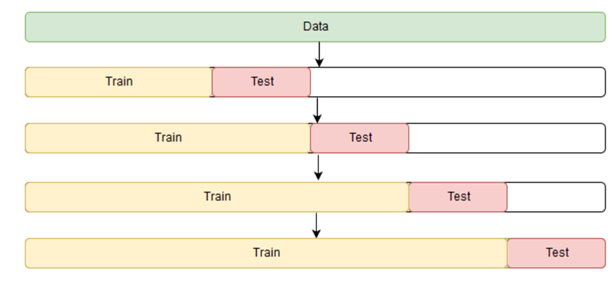

In [110]:
Image('img/ts_cross_validation.png')

In [111]:
model_results_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
model_results_cv.sort_values('RMSE')

,MAE,MAPE_manual,RMSE
Random forest regressor,853.71 +/- 257.13,0.12 +/- 0.03,1297.01 +/- 400.11
XGBoost regressor,1068.62 +/- 165.13,0.15 +/- 0.02,1531.94 +/- 235.94
Regressão linear,2081.69 +/- 295.28,0.3 +/- 0.02,2952.57 +/- 468.48
Regressão linear regularizada,2116.43 +/- 341.25,0.29 +/- 0.01,3057.75 +/- 503.93


Apesar do Random forest ter performado melhor neste momento, será feito o ajuste fino dos parâmetros do modelo XGBoos; um dos motivos para isso é que o XXGBoost, quando em produção, requer muito menos memória em relação ao RandomForest.

# 8. AJUSTE FINO DE HIPERPARÂMETROS
O objetivo é encontrar o conjunto de parâmetros que maximiza o aprendizado do modelo.

As 3 principais estratégias de ajuste de hiperparâmetros são:
1) Random search: <br>
    Vantagens: rápido, baixo custo e fácil de implemenar <br>
    Desvantagens: pode repetir conjuntos de parâmetros já testados e pode não selecionar o melhor conjunto de parâmtros para o modelo <br>

2) Grid search: <br>
    Vantagem: encontrar a melhor combinação de parâmetros que maximizam a performance do modelo (dentro do conjunto de valores disponíveis para cada um dos parâmetros) <br>
    Desvantagem: demorado e muito custoso computacionalmente <br>

3) Bayesian search: <br>
    Vantagens: é capaz de encontrar os valores dos parâmetros baseado em aprendizados passados, além de ser mais rápido que o grid search <br>
    Desvantagens: mais lento que o random search
    
Será implementando o random search por ser mais rápido, que é uma característica mandatória neste projeto.

## 8.1 Random search

In [112]:
## sessão desabilitada pelo alto tempo de processamento - 7h 42m 32s (e resultados idênticos)
## resultados compilados na tabela seguinte

#param = {
#    'n_estimators':  [1500, 1700, 2500, 3000, 3500],
#    'eta':  [0.01,0.03], 
#    'max_depth': [3,5,9],
#    'subsample': [0.1,0.5,0.7],
#    'colsample_bytree': [0.3,0.7,0.9],
#    'min_child_weight':[3,8,15]
#}


#final_result = pd.DataFrame()
#max_eval = 10


#for i in range(max_eval):
#    # escolha aleatória dos valores do dicionário
#    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
#    print(hp)

    ## parâmetros padrão do XGBoost
#    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
#                                 n_estimators = hp['n_estimators'],
#                                eta =  hp['eta'],
#                                 max_depth = hp['max_depth'],
#                                 subsample = hp['subsample'],
#                                 colsample_bytree = hp['colsample_bytree'],
#                                 min_child_weight = hp['min_child_weight']
#                           )

    ## CV
#    result = time_series_cross_validation(5, training_set,'XGBoost regressor', model_xgb,verbose=True)
#    final_result = pd.concat([final_result, result])

#final_result



In [113]:
resultados_finais = {'MAE': ['819.97 +/- 133.17',
                                '1429.38 +/- 155.06',
                                '803.45 +/- 148.08',
                                '1778.07 +/- 205.95',
                                '1314.99 +/- 167.76',
                                '875.68 +/- 153.02',
                                '1434.12 +/- 154.04',
                                '1665.99 +/- 184.88',
                                '1240.11 +/- 140.59',
                                '1286.88 +/- 150.43',
                                '1288.63 +/- 158.53',
                                '1199.55 +/- 146.86',
                                '910.01 +/- 134.73',
                                '1306.34 +/- 148.25'],
                        'MAPE_manual': ['0.11 +/- 0.01',
                                        '0.2 +/- 0.01',
                                        '0.11 +/- 0.01',
                                        '0.25 +/- 0.01',
                                        '0.18 +/- 0.01',
                                        '0.12 +/- 0.01',
                                        '0.2 +/- 0.01',
                                        '0.23 +/- 0.01',
                                        '0.17 +/- 0.01',
                                        '0.18 +/- 0.01',
                                        '0.18 +/- 0.01',
                                        '0.16 +/- 0.01',
                                        '0.13 +/- 0.01',
                                        '0.18 +/- 0.01'],
                        'RMSE': ['1186.38 +/- 203.43',
                                 '2071.52 +/- 204.79',
                                 '1174.34 +/- 235.99',
                                 '2555.52 +/- 284.45',
                                 '1908.63 +/- 226.44',
                                 '1273.37 +/- 243.37',
                                 '2082.6 +/- 206.7',
                                 '2407.18 +/- 250.03',
                                 '1794.51 +/- 191.54',
                                 '1864.99 +/- 205.9',
                                 '1879.64 +/- 217.16',
                                 '1738.76 +/- 203.14',
                                 '1307.57 +/- 196.17',
                                 '1891.86 +/- 204.63'],
                     'Parâmetros': ["'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15",
                                 "'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15",
                                 "'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15",
                                 "'n_estimators': 1500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3",
                                 "'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15",
                                 "'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8",
                                 "'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3",
                                 "'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15",
                                 "'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15",
                                 "'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3",
                                 "'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3",
                                 "'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3",
                                 "'n_estimators': 2500, 'eta': 0.03, 'max_depth': 6, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15",
                                 "'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8"]
                       }

print(tabulate(resultados_finais, headers=['MAE','MAPE','RMSE', 'Hiperparâmetros'], tablefmt="fancy_grid"))

╒════════════════════╤═══════════════╤════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ MAE                │ MAPE          │ RMSE               │ Hiperparâmetros                                                                                                      │
╞════════════════════╪═══════════════╪════════════════════╪══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ 819.97 +/- 133.17  │ 0.11 +/- 0.01 │ 1186.38 +/- 203.43 │ 'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15 │
├────────────────────┼───────────────┼────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ 1429.38 +/- 155.06 │ 0.2 +/- 0.01  │ 2071.52 +/- 204.79 │ 'n_estimators': 3000, 'eta': 0.03, 'max_depth

## 8.2 Final model

In [114]:
#param_tuned = {
#    'n_estimators': 1500 ,
#    'eta': 0.03 , 
#    'max_depth': 9,
#    'subsample': 0.7 ,
#    'colsample_bytree': 0.9 ,
#    'min_child_weight': 15
#}

## parâmetros padrão do XGBoost
#model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
#                                   n_estimators = param_tuned['n_estimators'],
#                                   eta = param_tuned['eta'],
#                                   max_depth = param_tuned['max_depth'],
#                                   subsample = param_tuned['subsample'],
#                                   colsample_bytree = param_tuned['colsample_bytree'],
#                                   min_child_weight = param_tuned['min_child_weight'] ).fit(x_train,y_train)

## prediction
#y_hat_xgb = model_xgb_tuned.predict(x_test)

## performance
#xgb_result_tuned = ml_error('XGBoost regressor',np.expm1(y_test),np.expm1(y_hat_xgb) )
#xgb_result_tuned



In [115]:
## para salvar o modelo (executado apenas uma vez)
#pickle.dump(model_xgb_tuned, open('model/model_rossmann.pkl', 'wb'))

# para carregar omodelo
model_xgb_tuned = pickle.load(open('model/model_rossmann.pkl', 'rb'))
y_hat_xgb = model_xgb_tuned.predict(x_test)
xgb_result_tuned = ml_error('XGBoost regressor',np.expm1(y_test),np.expm1(y_hat_xgb) )
xgb_result_tuned

,MAE,MAPE_manual,MAPE_sklearn,RMSE
XGBoost regressor,635.853387,0.092987,0.092987,928.257959


# 9. TRADUÇÃO E INTERPRETAÇÃO DO ERRO
Como entender a performance do modelo e dizer para o CEO o quanto, em dinheiro, esse modelo vai trazer para a empresa nas próximas seis semanas?

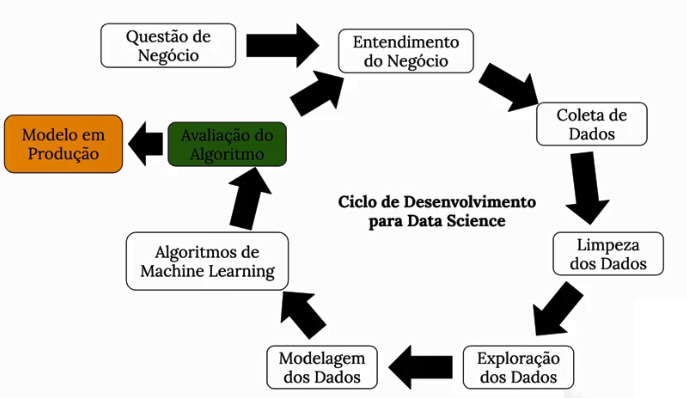

In [116]:
Image("img/crisp4.png")

In [117]:
# obtenção dos dados de venda (e previstos) na escala original

df9 = test_set.copy()

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = (np.expm1(y_hat_xgb))


Performance do modelo de regressão:
- MAE* (Mean Absolute Error)
- MAPE* (Mean Absolute Percentage Error)
- RMSE* (Root Mean Squared Error)
- MPE** (Mean Percentage Error)

*A diferença fundamental entre MAE/MAPE & RMSE é que os primeiros não são sensíveis à outliers, pois o erro é sempre absoluto, dividido pelo número de amostras.
Já o segundo, o erro é elevado ao quadrado, potencializando o impacto dele; posteriormente, é dividido pelo número da amostra antes de extrair a raiz quadrada.

** Útil para entender se o modelo está superestimando ou subestimando as predições

Performance do modelo sobre o negócio
- comparação com o status quo: como é feita a previsão de vendas atualmente vs proposta de previsão do modelo
- incremento de receita

# 9.1 MPE

O MPE não precisa ser calculado a cada treino de modelo, a menos que se deseje. Não é um erro usado para a valiar a performance dos modelos, apenas para relatar se o modelo está tendendo a subestimar ou superestimar o valor predito.


In [118]:
mpe = mean_percentage_error(np.expm1(y_test),np.expm1(y_hat_xgb))
mpe

0.0021346030813055904

Com o valor ligeiramente positivo, constata-se que há uma tendência em subestimar (ou seja, prever valores de vendas menores do que o real).

## 9.2 Business performance

In [261]:
# number of days
df9_aux0 = df9[['store','predictions']].groupby('store').count().rename(columns = {'predictions':'days'})

# soma das vendas
df9_aux1 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE & MAPE
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns = {0:'MAE'})
df9_aux3 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns = {0:'MAPE'})

# merge: dias + soma + MAE + MAPE
df9_aux4 = pd.merge(df9_aux2, df9_aux3, how='inner', on ='store')
df9_aux5 = pd.merge(df9_aux4, df9_aux0, how='inner', on ='store')
df9_1 = pd.merge(df9_aux1, df9_aux5, how='inner', on='store')


# criação dos cenários
df9_1['worst_scenario'] = df9_1['predictions'] - df9_1['days']*df9_1['MAE']
df9_1['best_scenario'] = df9_1['predictions'] + df9_1['days']*df9_1['MAE']

# export MAE to show in production (worst and best scenarios)
df9_1[['store','MAE']].to_csv('data/MAE.csv', index=False)

df9_1.head()


,store,predictions,MAE,MAPE,days,worst_scenario,best_scenario
0,1,161158.078125,280.176547,0.063653,37,150791.545898,171524.610352
1,2,179768.937500,335.415026,0.070614,37,167358.581543,192179.293457
2,3,261355.921875,532.673789,0.076960,37,241646.991699,281064.852051
3,4,342537.781250,870.745949,0.083565,37,310320.181152,374755.381348
4,5,173202.625000,376.188958,0.085442,37,159283.633545,187121.616455


In [120]:
# reorder columns
df9_1 = df9_1[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]
df9_1.sample(4, random_state = 746)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1059,1060,265308.093750,245007.463379,285608.724121,548.665686,0.080109
573,574,327169.531250,298944.631836,355394.430664,762.835119,0.076587
324,325,237289.734375,208127.763184,266451.705566,788.161384,0.147245
595,596,161856.218750,137612.406494,186100.031006,655.238169,0.127439


Nota-se que o MPAE por oscilar consideravelmente. Para visualizar a oscilação do erro pode-se plotar um ponto por loja com seu respectivo MAPE

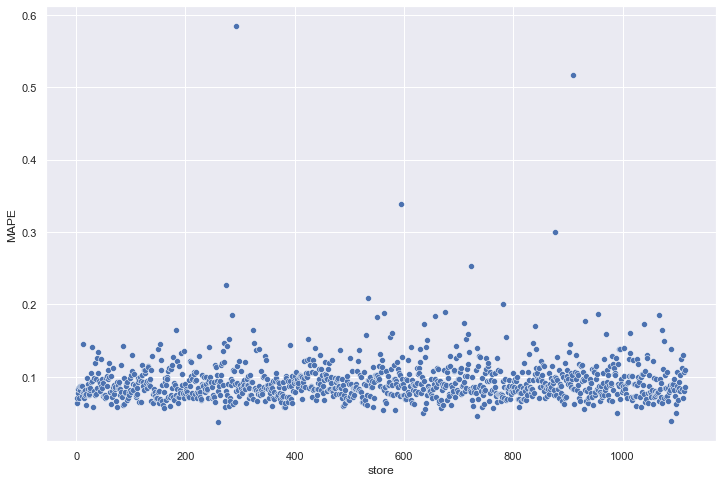

In [121]:
sns.scatterplot(x='store', y='MAPE', data = df9_1);

Não é recomendado tomar nenhuma decisão denegócio com base no modelo atual para as lojas que apresentam os maiores erros; recomenda-se, em futuros ciclos do CRISP, entender se há particularidades nessas lojas e, eventualmente, criar modelos específicos para elas.

## 9.3 Total performance

In [122]:
df_total_performance = pd.DataFrame(df9_1[['predictions', 'worst_scenario','best_scenario']].sum()).rename(columns = {0:'values'})
df_total_performance['values'] = df_total_performance['values'].map('R$ {:,.2f}'.format)
df_total_performance

,values
predictions,"R$ 283,811,008.00"
worst_scenario,"R$ 257,489,196.64"
best_scenario,"R$ 310,132,770.24"


Com isso, sabemos o valor total das predições, considerando o pior e o melhor cenário.

## 9.4 Machine learning performance

Para sumarizar a performance do modelo de machine learning, é gerado um conjunto de quatro gráficos.

In [123]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

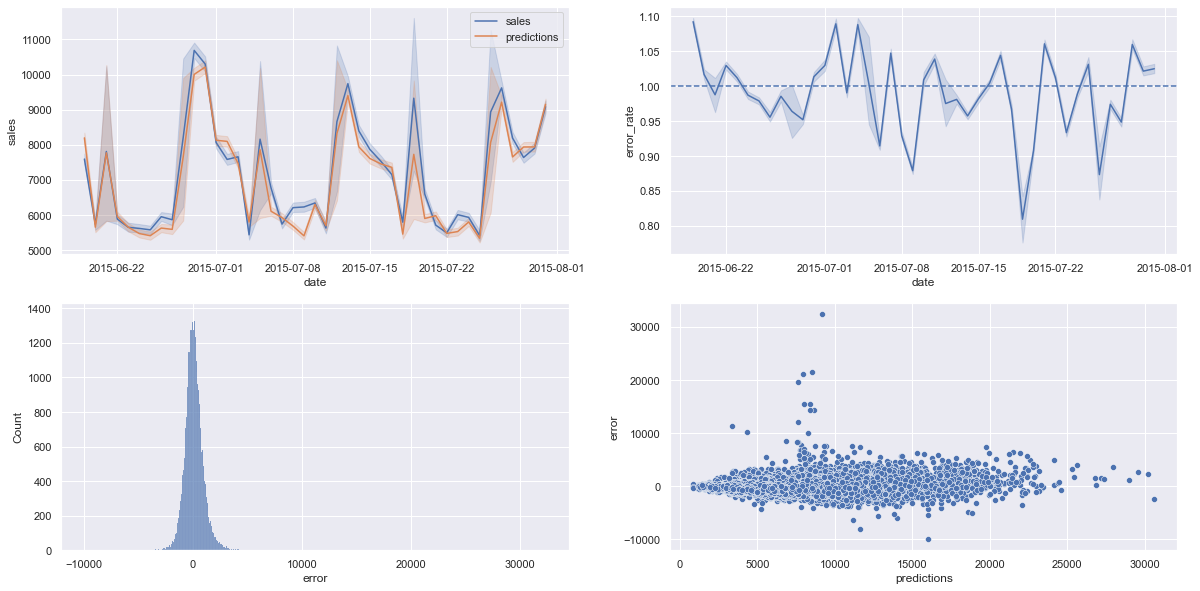

In [124]:
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'sales')
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'predictions')

plt.subplot(2,2,2)
sns.lineplot(x = 'date', y = 'error_rate', data = df9)
plt.axhline(1, linestyle = '--')

plt.subplot(2,2,3)
sns.histplot(data = df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(x = df9['predictions'], y = df9['error']);


Este conjunto de gráficos resume a performance do modelo. <br>
- O primeiro (superior esquerdo) mostra as vendas e suas respectivas previsões, considerando todas as lojas. <br>
- O segundo (superior direito) mostra a taxa de erro, onde abaixo de 1 é válido para os períodos onde onde ele subestimou e acima de 1 é válido para os períodos que ele superestimou. <br>
- O terceiro (inferior esquerdo) é a distribuição do erro, que se assemelha a uma distribuição normal. <br>
- O quarto (inferior direito) mostra os erros  pelo valor das predições; nota-se que os erros, para as previsões en torno de R$ 8k tendem a ser maiores, sendo que os maiores erros do modelo (os outliers) foram nessa faixa. <br>

Os dois últimos gráficos são utilizados em análise de resíduos, para ajudar a entender os pontos fracos do modelo e o que precisa fazer para aumentar a performance dele.

# 10. Modelo em produção
Com a performance do modelo compreendida, pode-se dizer que já está pronto para finalizar o primeiro ciclo do CRISP. Nesta etapa o modelo será colocado em produção para tornar as predições acessíveis para qualquer consumidor; e então, dependendo do feedback recebido e das prioridades da empresa, pode-se atuar em um segundo ciclo do CRISP ou partir para um novo projeto.

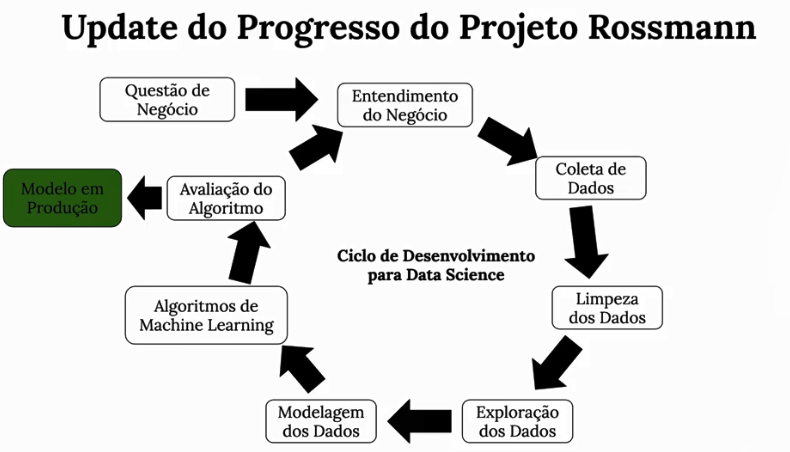

In [125]:
Image("img/crisp5.png")

A arquitetura do modelo em produção pode ser representada da seguinte maneira:

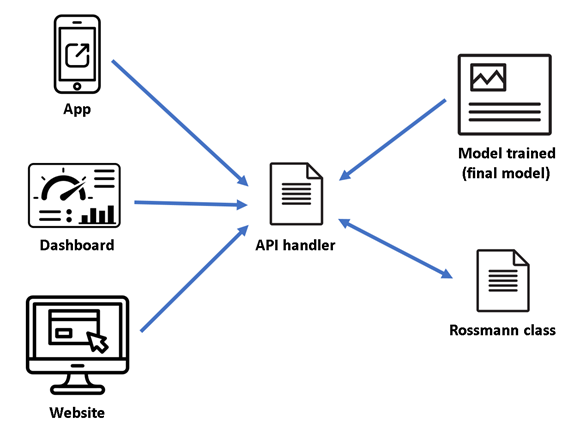

In [356]:
Image("img/schema_prod.png")

As próximas três subseções trazem os scripts do  "Rossmann class", "API handler" e um teste da API.

## 10.1. Rossmann class

In [285]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime
from sklearn.metrics import mean_absolute_error

class Rossmann(object):
    def __init__(self):
        self.home_path = r'C:\Users\RNFAVAR.EMBAD.000\Documents\NEO DIPAS\Ciencia de Dados na Embraer\repos\ds_em_producao'
        
        # ler o scaler ara utilizar na produção
        self.competition_distance_scaler = pickle.load(open(self.home_path + '\parameter\competition_distance_scaler.pkl','rb'))
        
        # ler o scaler para utilizar na produção
        self.competition_time_month_scaler = pickle.load(open(self.home_path + '\parameter\competition_time_month_scaler.pkl','rb'))
        
        # ler o scaler para utilizar na produção
        self.promo_time_week_scaler =  pickle.load(open(self.home_path + '\parameter\promo_time_week_scaler.pkl','rb'))
        
        # ler o scaler para utilizar na produção
        self.year_scaler =  pickle.load(open(self.home_path + '\parameter\year_scaler.pkl','rb'))
        
        # ler o scaler para utilizar na produção
        self.store_type_scaler = pickle.load(open(self.home_path + '\parameter\store_type_scaler.pkl', 'rb'))
        
        
    def data_cleaning(self,df1):
        # as mesmas seções previamente escritas são utilizadas para limpeza dos novos dados
        
        ## 1.1. Rename columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase,cols_old))
        df1.columns = cols_new
            
        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])
            
            
        ## 1.5. Fillout NA
        # competition_distance
        df1["competition_distance"] = df1["competition_distance"].fillna(200000)

        # competition_open_since_month
        x = lambda x: x["date"].month if math.isnan(x["competition_open_since_month"]) else x["competition_open_since_month"]
        df1["competition_open_since_month"] = df1.apply(x, axis=1)

        # competition_open_since_year
        x = lambda x: x["date"].year if math.isnan(x["competition_open_since_year"]) else x["competition_open_since_year"]
        df1["competition_open_since_year"] = df1.apply(x, axis=1)

        # promo2_since_week
        x = lambda x: x["date"].week if math.isnan(x["promo2_since_week"]) else x["promo2_since_week"]
        df1["promo2_since_week"] = df1.apply(x, axis=1)

        # promo2_since_year
        x = lambda x: x["date"].year if math.isnan(x["promo2_since_year"]) else x["promo2_since_year"]
        df1["promo2_since_year"] = df1.apply(x, axis=1)

        # promo_interval
        df1["promo_interval"].fillna(0, inplace = True)

        # month_map
        month_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug",9: "Sept", 10: "Oct", 11: "Nov",12: "Dec"}
        df1["month_map"] = df1["date"].dt.month.map(month_map)

        # is_promo
        df1["is_promo"] = df1[["promo_interval","month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(',') else 0, axis = 1)


        ## 1.6. Change Types
        df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
        df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)
        df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
        df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

        return df1
        
    def feature_engineering(self,df2):
        
        # 2.3. Feature Engineering

        # year
        df2["year"] = df2["date"].dt.year
        
        # month
        df2["month"] = df2["date"].dt.month
        
        # day
        df2["day"] = df2["date"].dt.day
        
        # week of year
        df2["week_of_year"] = df2["date"].dt.isocalendar().week
        
        # year week
        df2["year_week"] = df2["date"].dt.strftime('%Y-%W')

        # competition_time_month
        df2["competition_since"] = df2.apply(lambda x: datetime.datetime(year = x["competition_open_since_year"], month = x["competition_open_since_month"], day = 1), axis = 1)
        df2["competition_time_month"] = ((df2["date"] - df2["competition_since"]) / 30).apply(lambda x: x.days).astype(int)

        # promo_time_week
        df2["promo_since"] = df2["promo2_since_year"].astype(str) +  '-' + df2["promo2_since_week"].astype(str)
        df2["promo_since"] = df2["promo_since"].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))
        df2["promo_time_week"] = ((df2["date"] - df2["promo_since"])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2["assortment"] = df2["assortment"].map({'a': 'basic', 'b': 'extra', 'c': 'extended'})
        
        # state holiday
        df2["state_holiday"] = df2["state_holiday"].map({'a':'public_holiday', 'b':'easter_holiday', 'c':'christmas', '0': 'regular_day'})
        
        # 3.1. Filtragem das linhas
        df2 = df2[df2['open'] != 0]
        
        # 3.2. Seleção das colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    
    def data_preparation(self,df5):
    
        # 5.2 Rescaling
        # originalmente a series 'week_of_year' está como tipo UInt32; faz-se a conversão.
        df5['week_of_year'] = df5['week_of_year'].astype(np.int64)

        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        # promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)


        # 5.3.1. Enconding
        # state_holiday
        df5 = pd.get_dummies(data=df5,prefix='state_holiday',columns=['state_holiday'])

        # store_type
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment
        assortment_dict = {'basic':1, 'extra':2, 'extended':3} 
        df5['assortment'] = df5['assortment'].map(assortment_dict)


        # 5.3.3. Trnasformação de natureza
        #month
        df5['month_sin'] = df5['month'].apply(lambda x : np.sin(x * (2 * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x : np.cos(x * (2 * np.pi / 12)))


        #day
        max_days_month = df5.groupby('month')['day'].max().to_dict()
        df5['max_days_month'] = df5['month'].map(max_days_month)

        x = lambda x: np.sin(x['day'] * (2 * np.pi / x['max_days_month']))
        df5['day_sin'] = df5.apply(x, axis=1)

        x = lambda x: np.cos(x['day'] * (2 * np.pi / x['max_days_month']))
        df5['day_cos'] = df5.apply(x, axis=1)

        df5.drop(columns='max_days_month',inplace=True)


        #week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x : np.sin(x * (2 * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x : np.cos(x * (2 * np.pi / 52)))

        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x : np.sin(x * (2 * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x : np.cos(x * (2 * np.pi / 7)))
        
        cols_selected = ['store','promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                         'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                         'promo_time_week','month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin','week_of_year_cos', 
                         'day_of_week_sin', 'day_of_week_cos']

        return df5[cols_selected]
    
    def get_prediction(self,model,original_data, test_data):
        pred = model.predict(test_data)
        
        # join pred into original data
        original_data['prediction'] = np.expm1(pred)
        
        # load MAE
        df_mae = pd.read_csv(r'C:\Users\RNFAVAR.EMBAD.000\Documents\NEO DIPAS\Ciencia de Dados na Embraer\repos\ds_em_producao\data\MAE.csv')
        
        # merge with MAE
        df_response_with_MAE = pd.merge(original_data, df_mae, how='left', on='store')
        
        # scenarios
        df_response_with_MAE['best_scenario'] = df_response_with_MAE['prediction'] + df_response_with_MAE['MAE']
        df_response_with_MAE['worst_scenario'] = df_response_with_MAE['prediction'] - df_response_with_MAE['MAE']
        
        
        return df_response_with_MAE.to_json(orient='records', date_format = 'iso')
        
        

## 10.2. API handler

In [339]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# load model
model = pickle.load(open(r'C:\Users\RNFAVAR.EMBAD.000\Documents\NEO DIPAS\Ciencia de Dados na Embraer\repos\ds_em_producao\model\model_rossmann.pkl', 'rb'))

app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
        # se o json for único (ou seja, um dicionário)
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        # se não for único, cria o dataframe considerando as chaves do json
        else:       
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
            
        # instanciar a Rossmann class
        pipeline = Rossmann()
        
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)       
       
        return df_response
        
        
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API tester

In [343]:
import requests

In [350]:
# load test dataset
df10 = pd.read_csv(r'C:\Users\RNFAVAR.EMBAD.000\Documents\NEO DIPAS\Ciencia de Dados na Embraer\repos\ds_em_producao\data\test.csv')
df_test = pd.merge(df10,df_store_raw, how='left', on = 'Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([24,12,22,909,946,292])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()] # some 'Open' values are null; these rows cannot be used
df_test = df_test.drop(columns = ['Id'])

In [351]:
# convert dataframe to a json list
data = json.dumps(df_test.to_dict(orient = 'records'))

In [352]:
# API call
url = 'http://192.168.15.7:5000/rossmann/predict'
header = {'Content-type':'application/json'} # type of requisition
data = data

r = requests.post(url,data=data, headers = header)
print(f'Status code {r.status_code}')

Status code 200


In [353]:
df_resp = pd.DataFrame(r.json())
df_resp.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction,MAE,best_scenario,worst_scenario
0,12,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,9,2015,1,13,2010,"Jan,Apr,Jul,Oct",Sept,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,8572.953125,618.055822,9191.008947,7954.897303
1,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sept,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,5676.320312,406.716830,6083.037142,5269.603483
2,24,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,4590.0,3,2000,1,40,2011,"Jan,Apr,Jul,Oct",Sept,0,2015,9,17,38,2015-37,2000-03-01T00:00:00.000Z,189,2011-09-26T00:00:00.000Z,207,12719.445312,692.932076,13412.377389,12026.513236
3,909,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1680.0,9,2015,1,45,2009,"Feb,May,Aug,Nov",Sept,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2009-11-02T00:00:00.000Z,306,9651.309570,7662.194930,17313.504501,1989.114640
4,946,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,2220.0,12,2011,1,14,2015,"Jan,Apr,Jul,Oct",Sept,0,2015,9,17,38,2015-37,2011-12-01T00:00:00.000Z,46,2015-03-30T00:00:00.000Z,24,6409.794434,245.897725,6655.692158,6163.896709


In [354]:
df_pred = df_resp[['store','prediction','worst_scenario','best_scenario']].groupby('store').sum().reset_index()

for i in range(len(df_pred)):
     print("Store number {} will sell R$ {:,.2f} (may vary between R$ {:,.2f} and R$ {:,.2f} ) in the next 6 weeeks.".format(df_pred.loc[i, 'store'],
                                                                                                                            df_pred.loc[i, 'prediction'],
                                                                                                                            df_pred.loc[i, 'worst_scenario'],
                                                                                                                            df_pred.loc[i, 'best_scenario']))

Store number 12 will sell R$ 240,092.46 (may vary between R$ 214,752.17 and R$ 265,432.75 ) in the next 6 weeeks.
Store number 22 will sell R$ 154,046.62 (may vary between R$ 137,777.95 and R$ 170,315.29 ) in the next 6 weeeks.
Store number 24 will sell R$ 392,200.38 (may vary between R$ 363,790.16 and R$ 420,610.59 ) in the next 6 weeeks.
Store number 909 will sell R$ 274,380.83 (may vary between R$ -24,444.77 and R$ 573,206.44 ) in the next 6 weeeks.
Store number 946 will sell R$ 184,600.10 (may vary between R$ 174,518.29 and R$ 194,681.90 ) in the next 6 weeeks.


# X. Segundo ciclo CRISP

In [126]:
# ao usar a com a feature customers os erros caem consideeravelmente.
# por exemplo, o cv da seção 7.5.1. (XGBoost regressor) resulta nos erros abaixo:
# 468.66 +/- 53.4	0.06 +/- 0.0	663.77 +/- 82.64
# portanto, seria interessante mencionar que usar a feature customers pode representar um incremento na performance.
# por outro lado, como não temos a feature disponível no momento da venda, é importante que seja feito um projeto exclusivo para os clientes
# então com o número dos clientes estimados, alimenta-se o projeto das vendas e faz-se a predição.
# as features para clientes podem ser: densidade demográfica da região da farmácia, população/qtde de farmácias da cidade, cidade turística ou não, competidor mais próximo, dia chuvoso ou não.
# enfim tudo o que possa influenciar o cliente. A feature feriado, por exemplo, não influencia o cliente pois todos elees estão sob o mesmo feriado. 
# O feriado influencia as vendas, ou seja, o comportamento no ato de comprar.